# Import

The link to our datastory: https://math-ruch.github.io/yamal_group/

In [104]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import warnings
import vaderSentiment
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import qqplot

from utils import *
from nltk import tokenize
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from IPython.display import Image, display
from scipy import stats
from scipy.stats import f_oneway, ttest_ind
from scipy.optimize import linear_sum_assignment
import networkit as nk
warnings.filterwarnings('ignore', category=FutureWarning)

/Users/aminebelghmi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 1. CMU DATASET ANALYSIS

In [2]:
DATA_FOLDER = './datasets/'

In [3]:
# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB',
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name',
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER + 'CMU_dataset/character.metadata.tsv', names=columns_char,
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

# Loading movies
columns_mov = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Movie_name', 'Movie_release_date',
               'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
               'Movie_genres']

cmu_df = pd.read_table(DATA_FOLDER + 'CMU_dataset/movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

Load plot and merge with CMU movie dataframe

In [4]:
plot_df = pd.read_csv("./datasets/CMU_Dataset/plot_summaries.txt", names = ['Wikipedia_Movie_ID', 'Movie_plot'], 
                      sep="\t")

We perform a left merge on the CMU movie data frame so that it remains unchanged regarding the number of movies. A new column containing the plot is created.

In [5]:
cmu_df = pd.merge(right=plot_df, left=cmu_df, on='Wikipedia_Movie_ID', how='left')

The goal of our study is to analyze what factors contribute to the success of a movie. Let us first have a quick analysis on our provided data set.


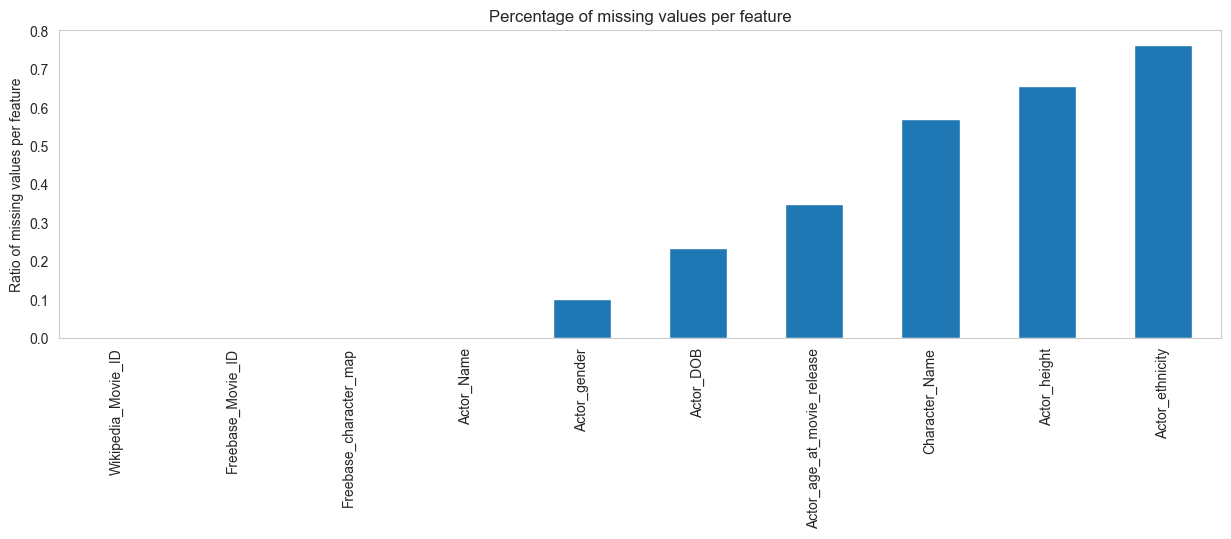

In [6]:
plot_missing_values_percentage(characters)

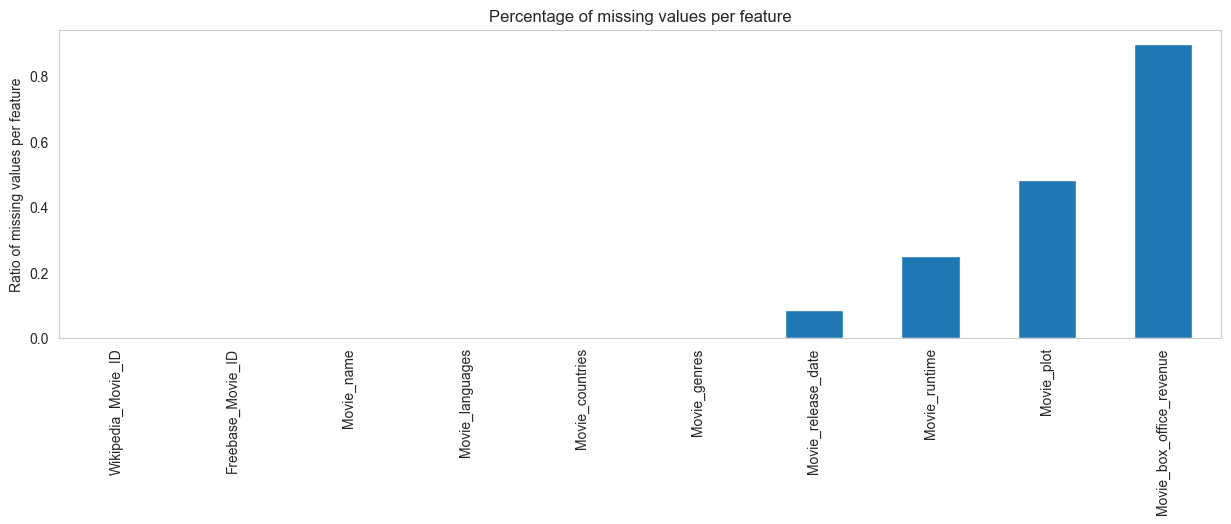

In [7]:
plot_missing_values_percentage(cmu_df)

**Comment:** Good factors to measure the success of a movie are its ratings and its revenues. We can see that our data set does not contain any information on movie ratings, and has a very high percentage of missing values for the movie revenues.
**Solution:** Merge the CMU dataset with our additional dataset that contains ratings informations and additional box office revenues

### Creating a mapping between the IMDB Id and the Freebase_Movie_ID

In [8]:
data = query_wikidata()

In [9]:
imbd_freebase = json_to_df(data)

In [10]:
imbd_freebase.drop_duplicates(subset=['imdb_id', 'freebase_id'], inplace=True)

# 2. TMBD Analysis

In [11]:
pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')

/var/folders/20/2kn9rjns09d18w17wc_48kr00000gn/T/ipykernel_61529/885709851.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')


### Drop Non-related Columns

In [12]:
pd_tmbd = pd_tmbd.drop(
    ['adult', 'belongs_to_collection', 'homepage', 'original_title', 'overview', 'poster_path', 'status', 'tagline',
     'video'], axis=1)

#### Evaluate the literal value to convert it to array

In [13]:
# Apply the function to the corresponding columns
column_names = ['genres', 'production_companies', 'production_countries', 'spoken_languages']
for column in column_names:
    pd_tmbd[column] = pd_tmbd[column].apply(lambda x: safe_literal_eval(x))
    pd_tmbd[column] = pd_tmbd[column].apply(lambda x: get_names(x))


# 3. Merging the CMU and the TMDB Datasets

In [14]:
cmu_df = pd.merge(left=cmu_df, right=imbd_freebase, right_on='freebase_id', left_on='Freebase_Movie_ID',
                  how='inner').drop(columns='freebase_id')

In [15]:
movies = pd.merge(right=cmu_df, left=pd_tmbd, on='imdb_id', how='inner').drop_duplicates(subset='imdb_id')

### Replace with NaN values

In [16]:
movies['popularity'] = movies['popularity'].astype(float)
movies['popularity'].replace(0.0, np.nan, inplace=True)

movies['budget'] = movies['budget'].astype(float)
movies['budget'].replace(0.0, np.nan, inplace=True)

movies['revenue'].replace(0.0, np.nan, inplace=True)
movies['Movie_box_office_revenue'].replace(0.0, np.nan, inplace=True)

In [17]:
movies['Movie_box_office_revenue'] = movies['Movie_box_office_revenue'].fillna(movies['revenue'])
movies.drop(columns='revenue', inplace=True)

### Preprocessing the genres, languages and countries columns

**Comment:** We have the columns mentioned above are represented as dictionaries with key freebase_id and values country names, genres and languages of the movie with id freebase_id, that's why we decided to retrieve the values and store them instead of having the dictionary representation

In [18]:
movies['Movie_genres'] = movies['Movie_genres'].apply(transform_row)
movies['Movie_countries'] = movies['Movie_countries'].apply(transform_row)
movies['Movie_languages'] = movies['Movie_languages'].apply(transform_row)

In [19]:
movies.drop(columns=['Wikipedia_Movie_ID', 'title', 'runtime', 'original_language', 'production_companies', 'id',
                     'Movie_genres'], axis=1, inplace=True)

### Preprocessing the release date column

**We have two release date columns 'release_date' of the TMDB dataset and 'Movie_release_date' of the CMU dataset. Let us compare between the two columns to decide which one to drop**

In [20]:
columns_to_check = ['Movie_release_date', 'release_date']

for column in columns_to_check:
    movies['date_format_' + column] = movies[column].apply(
        lambda date: determine_date_format(str(date)))
    print(f"Date formats in {column}:")
    print(movies['date_format_' + column].value_counts())
    print()

Date formats in Movie_release_date:
date_format_Movie_release_date
yyyy-mm-dd    16505
yyyy           9344
unknown        1581
Name: count, dtype: int64

Date formats in release_date:
date_format_release_date
yyyy-mm-dd    27423
unknown           7
Name: count, dtype: int64



After this comparison between the two release date columns, we decided to use the release date column from the tmdb dataset, because it represents the date of movies in the same format yyyy-mm-dd.Also, given the count of unknown release date format we conclude that there is 7 missing values in this column.
We transform the release date to 3 columns, namely year, month and day. To do so, we change the type of the release date column from string to Date-time representation. From that, we will extract the year, month and day of each movie’s release date.

In [21]:
# Drop the 7 unknown formats
movies = movies[movies['date_format_release_date'] != 'unknown']
# Drop the non-useful columns
movies.drop(columns=['date_format_Movie_release_date', 'date_format_release_date', 'Movie_release_date'],
                     axis=1, inplace=True)

In [22]:
# Convert 'release_date' to datetime
movies['release_date'] = pd.to_datetime(movies['release_date'], errors='coerce')

# Extract year, month, and day of each movie into separate columns
movies['year'] = movies['release_date'].dt.year
movies['month'] = movies['release_date'].dt.month
movies['day_week'] = movies['release_date'].dt.day_name()

In [23]:
display(movies[['release_date', 'year', 'month', 'day_week']])

,release_date,year,month,day_week
0,1995-10-30,1995,10,Monday
1,1995-12-15,1995,12,Friday
2,1995-12-22,1995,12,Friday
3,1995-12-22,1995,12,Friday
4,1995-02-10,1995,2,Friday
...,...,...,...,...
27447,1972-01-01,1972,1,Saturday
27448,1946-03-29,1946,3,Friday
27449,1991-05-13,1991,5,Monday
27450,2003-08-01,2003,8,Friday


## Adjusting movies dataframe to account for inflation

Since we are considering movies on a large time window, we need to account for inflation. Otherwise, recent movies will have a clear advantage on older movies when accounting for variables like the budget or th box office revenue. To do so, we import a new dataset of US consumer price over the years. For each movie, we calculate the inflation factor from its release year to the present year 2020. Using CPI, the factor can be calculated as CPI in current year / CPI in release year. For simplicity, we are not going to consider the variations of the CPI within each year, we are only going to say that the CPI for a given year is the CPI on january.

In [24]:
# reading the inflation dataframe
inflation = pd.read_csv(DATA_FOLDER+'KAGGLE_dataset/US CPI.csv')

In [25]:
# Calculate Annual CPI by computing the mean
inflation['Yearmon'] = pd.to_datetime(inflation['Yearmon'], format='%d-%m-%Y')
inflation['Year'] = inflation['Yearmon'].dt.year
annual_cpi = inflation.groupby('Year')['CPI'].mean()
# Create a CPI mapping from year to annual CPI
cpi_mapping = annual_cpi.to_dict()
# Adding the corresponding CPI index the movies dataframe
movies['annual_cpi'] = movies['year'].map(cpi_mapping)

In [26]:
# Choose the most recent year in your dataset as the base year
base_year = movies['year'].max()
base_year_cpi = cpi_mapping[base_year]

In [27]:
# Apply the inflation adjustment
movies = movies.apply(adjust_for_inflation, axis=1, args=(base_year_cpi,))

In [28]:
movies.drop(columns=['annual_cpi'],
                     axis=1, inplace=True)

### Calculate the Net profit for every movie

In [29]:
movies['Net profit'] = movies['Movie_box_office_revenue'] - movies['budget']

### Calculate the Return On Investment (ROI)

In [30]:
# Calculate Return on Investment (ROI) as a percentage for each movie
movies['ROI'] = movies['Net profit'] / movies['budget']

In [31]:
# Reorder the columns of the movie dataset
movies = movies[
    ['Freebase_Movie_ID', 'imdb_id', 'Movie_name', 'release_date', 'year', 'month', 'day_week', 'genres', 'spoken_languages',
     'Movie_languages', 'Movie_countries', 'budget', 'Movie_box_office_revenue',
     'Net profit', 'ROI', 'popularity', 'Movie_runtime', 'vote_average', 'vote_count', 'Movie_plot']]

display(movies)


,Freebase_Movie_ID,imdb_id,Movie_name,release_date,year,month,day_week,genres,spoken_languages,Movie_languages,Movie_countries,budget,Movie_box_office_revenue,Net profit,ROI,popularity,Movie_runtime,vote_average,vote_count,Movie_plot
0,/m/0dyb1,tt0114709,Toy Story,1995-10-30,1995,10,Monday,"[Animation, Comedy, Family]",[English],[English Language],[United States of America],5.095265e+07,6.147586e+08,5.638059e+08,11.065291,21.946943,77.0,7.7,5415.0,Woody is a pull-string cowboy doll and leader...
1,/m/09w353,tt0113497,Jumanji,1995-12-15,1995,12,Friday,"[Adventure, Fantasy, Family]","[English, Français]","[French Language, English Language]","[United States of America, Japan]",1.103974e+08,4.463406e+08,3.359431e+08,3.043035,17.015539,104.0,6.9,2413.0,"In 1869, two boys bury a game board in a fore..."
2,/m/0676dr,tt0113228,Grumpier Old Men,1995-12-22,1995,12,Friday,"[Romance, Comedy]",[English],"[Italian Language, English Language]",[United States of America],NaN,1.214686e+08,NaN,NaN,11.712900,101.0,6.5,92.0,The lifelong feud between Max and John has c...
3,/m/03vny7,tt0114885,Waiting to Exhale,1995-12-22,1995,12,Friday,"[Comedy, Drama, Romance]",[English],[English Language],[United States of America],2.717475e+07,1.383401e+08,1.111654e+08,4.090760,3.859495,121.0,6.1,34.0,Waiting to Exhale is a story about four Africa...
4,/m/094g2z,tt0113041,Father of the Bride Part II,1995-02-10,1995,2,Friday,[Comedy],[English],[English Language],[United States of America],NaN,1.300891e+08,NaN,NaN,8.387519,106.0,5.7,173.0,George Banks must accept the reality of what h...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27447,/m/0crtfny,tt0069215,St. Michael Had a Rooster,1972-01-01,1972,1,Saturday,[],[Italiano],[Italian Language],[Italy],NaN,NaN,NaN,NaN,0.225051,90.0,6.0,3.0,NaN
27448,/m/0bf79j,tt0038621,House of Horrors,1946-03-29,1946,3,Friday,"[Horror, Mystery, Thriller]",[English],[English Language],[United States of America],NaN,NaN,NaN,NaN,0.222814,65.0,6.3,8.0,"Struggling sculptor, Marcel DeLange is depres..."
27449,/m/0g0dy6,tt0102797,Robin Hood,1991-05-13,1991,5,Monday,"[Drama, Action, Romance]",[English],[English Language],[United Kingdom],NaN,NaN,NaN,NaN,5.683753,116.0,5.7,26.0,"The film begins when a miller, who is poaching..."
27450,/m/065ztgt,tt0303758,Betrayal,2003-08-01,2003,8,Friday,"[Action, Drama, Thriller]",[English],[English Language],[United States of America],NaN,NaN,NaN,NaN,0.903007,90.0,3.8,6.0,NaN


# Sub-Question 1: Does the period of release of a movie have an impact on its box office revenue?

In [32]:
movies_revenues = movies.copy().dropna(subset=['Movie_box_office_revenue']).reset_index(drop=True)
print(f"The number of movies with box office revenue is : {len(movies_revenues)}")

The number of movies with box office revenue is : 9147


*Let's analyze the distributions of the 9147 movies*

### Year distribution and its relationship with the box office revenue

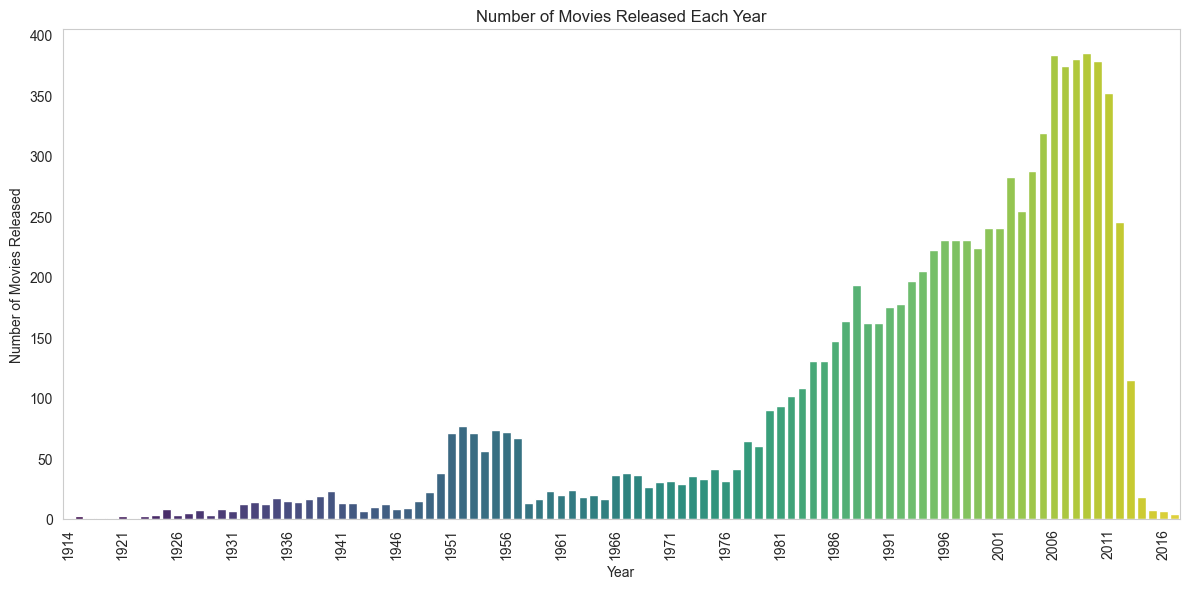

In [33]:
# Calculate the number of movies released each year and sort the data by year.
yearly_counts = movies_revenues['year'].value_counts().sort_index()

# Set up the figure size and the style for better clarity and aesthetics.
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Create a bar plot to show the number of movies released each year using the 'viridis' color palette for visibility.
# The 'hue' parameter assigns a different shade to each bar, making each year distinct.
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='viridis')

# Generate tick labels that only label every 5 years to avoid cluttering the x-axis.
tick_labels = [str(year) if i % 5 == 0 else '' for i, year in enumerate(yearly_counts.index)]
plt.xticks(ticks=np.arange(len(yearly_counts.index)), labels=tick_labels, rotation=90)

# Label the x-axis and y-axis for clarity.
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')

# Add a title to the plot for better context.
plt.title('Number of Movies Released Each Year')

# Set 'plt.grid(False)' to remove the grid for a cleaner look.
plt.grid(False)

# Remove the legend since it is unnecessary after assigning colors to each bar.
plt.legend([], [], frameon=False)

# Ensure the plot is displayed well without overlapping elements.
plt.tight_layout()
plt.show()

*This histogram displays the count of movies released annually, revealing a clear upward trend in the film industry's output. The growth becomes more pronounced in recent decades, indicating a significant expansion in movie production.*

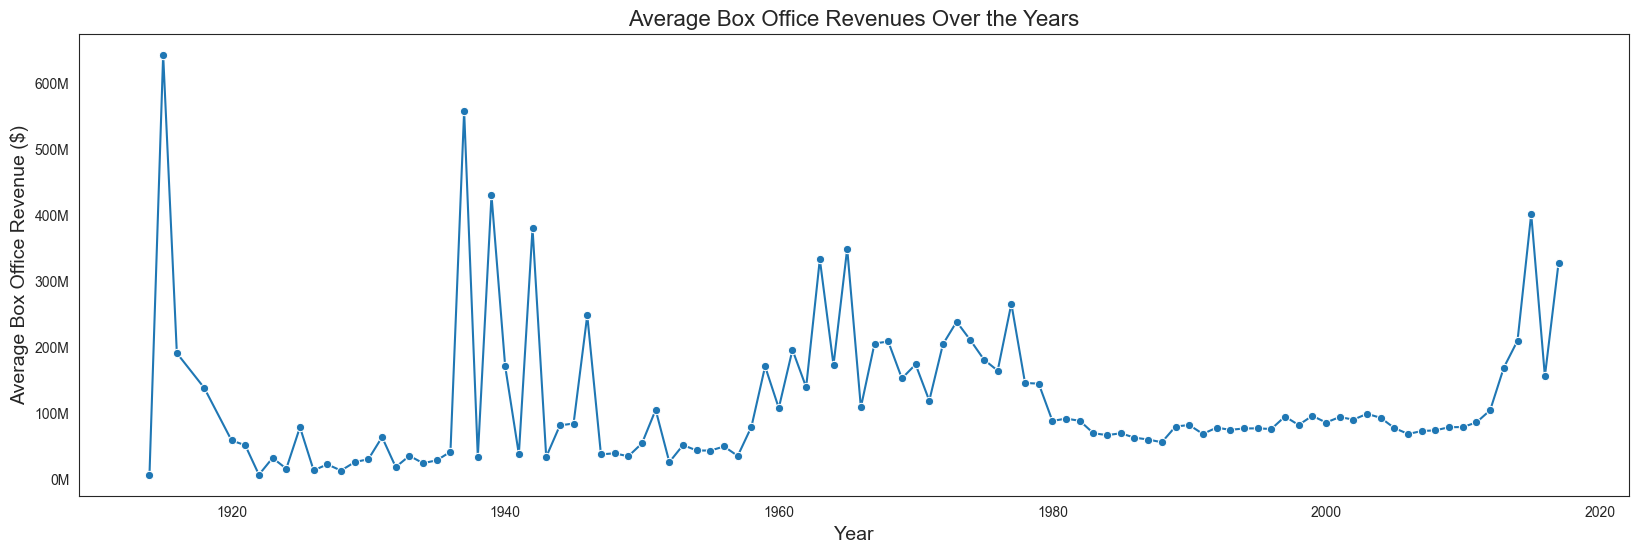

In [54]:
# Aggregating yearly data for analysis
yearly_stats = movies_revenues.groupby('year').apply(
    lambda df: pd.Series({
        'avg_box_office_revenue': df['Movie_box_office_revenue'].mean(),  # Calculate the average revenue per year
    })
)

# Setting the aesthetic style of the plots
sns.set_style("white")

def millions_formatter(x, pos):
    return f'{int(x / 1_000_000)}M'


plt.figure(figsize=(20, 6))
ax = sns.lineplot(x=yearly_stats.index, y='avg_box_office_revenue', data=yearly_stats, marker='o')

# Defining the title and labels
plt.title('Average Box Office Revenues Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)

# Set the formatter for the y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# Display the plot
plt.show()

### Month distribution and its relationship with the box office revenue

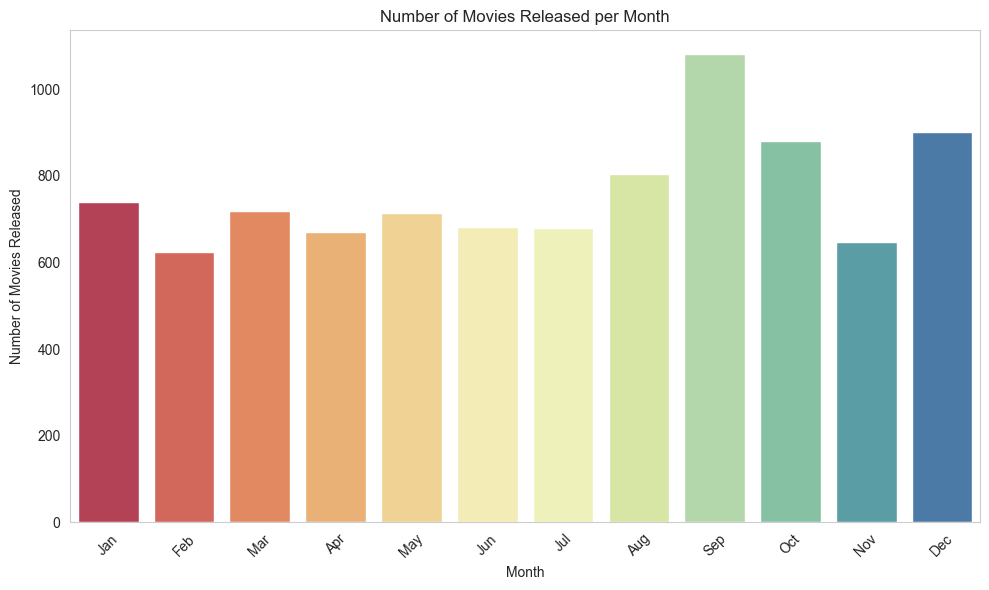

In [35]:
# Group movies by month and count the number of movies released each month
monthly_counts = movies_revenues.groupby('month').size()

# Set up the figure size for the plot
plt.figure(figsize=(10, 6))

# Apply a white grid style for the plot background
sns.set_style('whitegrid')

# Create a bar plot to show the number of movies released each month, using a 'Spectral' color palette for better visualization
# Use 'hue' to assign different colors to each bar
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette='Spectral', dodge=False)

# Set the x-ticks and labels to display all months and rotate them for better readability
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=45)

# Label the x-axis and y-axis
plt.xlabel('Month')
plt.ylabel('Number of Movies Released')

# Add a title to the plot
plt.title('Number of Movies Released per Month')

# Remove the grid from the plot for a cleaner look
plt.grid(False)

# Remove the legend as it is unnecessary in this context
plt.legend([], [], frameon=False)

# Adjust the plot layout to make sure everything fits well
plt.tight_layout()
plt.show()

*This bar chart shows the number of movies released each month. We see the highest releases in September and October, indicating a possible preference for launching films during fall season.*

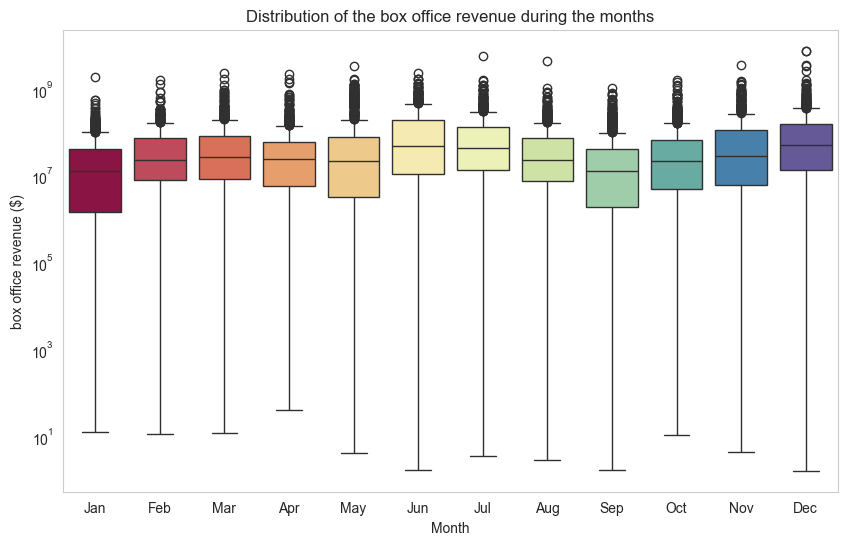

In [36]:
# Set the style of the plot to 'whitegrid' for a clean background with grid lines
sns.set_style('whitegrid')

# Set the size of the figure for the plot
plt.figure(figsize=(10, 6))

# Create a box plot to show the distribution of box office revenue across different months
# Use the 'Spectral' palette to assign colors to each month and disable the dodge option
sns.boxplot(x="month", y="Movie_box_office_revenue", hue="month",
            data=movies_revenues, palette='Spectral', dodge=False)

# Set the x-ticks to display all months and label them accordingly
plt.xticks(ticks=range(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# Title the plot to describe what it is showing
plt.title("Distribution of the box office revenue during the months")

# Label the x-axis as "Month" and y-axis as "box office revenue ($)"
plt.xlabel("Month")
plt.ylabel("box office revenue ($)")

# Set the y-axis scale to logarithmic to better display the wide range of values
plt.yscale("log")

# Remove the grid for a cleaner appearance
plt.grid(False)

# Remove the legend because the colors are already explained in the x-axis labels
plt.legend([], [], frameon=False)
plt.show()

*This box plot visualizes the spread of monthly box office revenues, highlighting the variability within each month. The logarithmic scale captures the wide range of revenues, from modest to blockbuster hits.*

### Day distribution and its relationship with the box office revenue

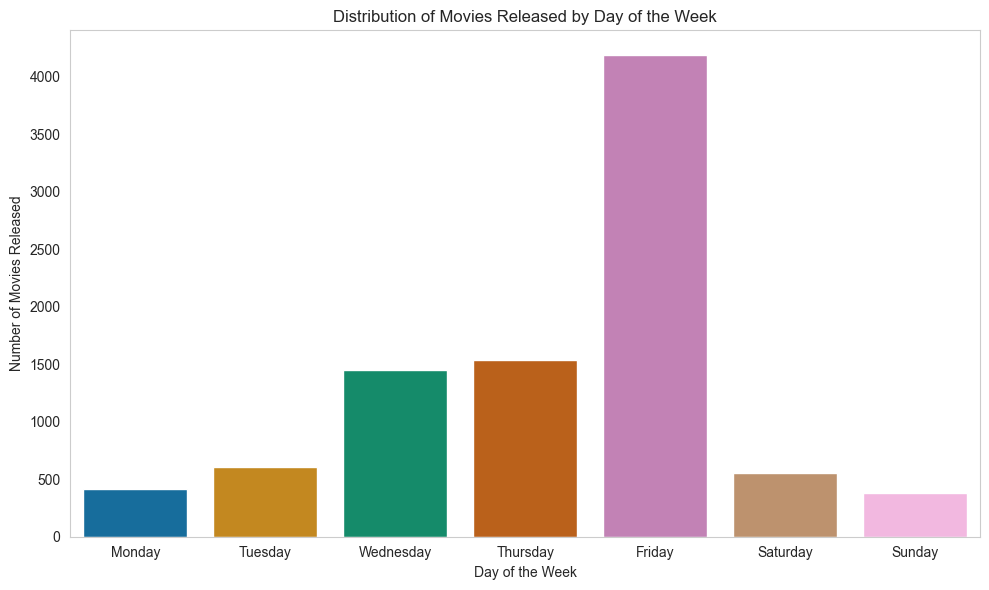

In [37]:
# Define the correct order of days in the week
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group movies by day of the week and count the number of movies released each day
day_counts = movies_revenues.groupby('day_week').size()

# Reorder the 'day_counts' series according to the predefined order of 'ordered_days' to maintain logical sequencing in the plot
day_counts = day_counts.loc[ordered_days]

# Set up the figure size for the bar plot
plt.figure(figsize=(10, 6))

# Apply a white grid style for the plot background to enhance readability and aesthetics
sns.set_style('whitegrid')

# Create a bar plot to visualize the number of movies released on each day of the week
# 'colorblind' palette is used to assist viewers with color vision deficiencies
# 'dodge' set to 'False' to avoid shifting the bars and maintain a consistent layout
sns.barplot(x=day_counts.index, y=day_counts.values, palette='colorblind', hue=day_counts.index, dodge=False)

# Label the x-axis 'Day of the Week' and the y-axis 'Number of Movies Released' for clarity
plt.xlabel('Day of the Week')
plt.ylabel('Number of Movies Released')

# Add a title to the bar plot to provide context
plt.title('Distribution of Movies Released by Day of the Week')

# Disable the grid lines on the plot for a cleaner look
plt.grid(False)
# Remove the legend because the colors are already explained in the x-axis labels
plt.legend([], [], frameon=False)

# Adjust the layout of the plot to ensure it is well-organized and elements are displayed properly
plt.tight_layout()
plt.show()

*This bar chart shows the number of movies released on each day of the week. Friday is the most popular day for movie releases, with significantly fewer movies coming out at the start of the week.*

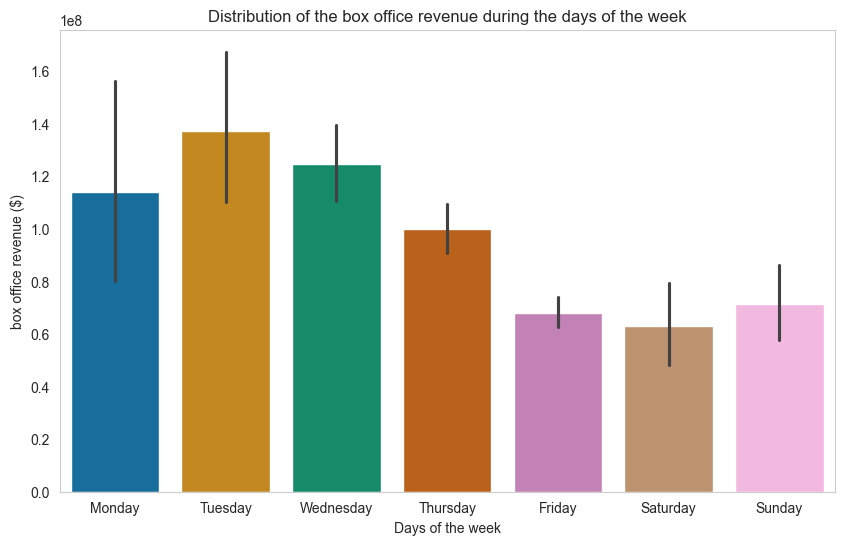

In [38]:
# Define a dictionary to map the days of the week to a numerical order, with Monday as 0 and Sunday as 6.
day_order = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Apply the 'day_order' dictionary to create a new 'day_order' column,
# which assigns each day of the week its corresponding numerical order for sorting purposes.
movies_revenues['day_order'] = movies_revenues['day_week'].apply(lambda x: day_order[x])

# Sort the DataFrame based on the 'day_order' column to ensure the data is ordered from Monday to Sunday.
movies_revenues.sort_values('day_order', inplace=True)

plt.figure(figsize=(10, 6))

# Set the plotting style to 'whitegrid' which adds grid lines for better readability of the plot.
sns.set_style('whitegrid')

# Create a barplot that shows the box office revenue distribution across different days of the week.
# The 'colorblind' palette is used to ensure the plot is accessible to individuals with color vision deficiencies.
# The 'dodge' parameter is set to 'False' to keep the bars for each day aligned without any offset.
sns.barplot(x="day_week", y="Movie_box_office_revenue", hue="day_week",
            data=movies_revenues, palette='colorblind', dodge=False)

# Add a title to the plot for better context.
plt.title("Distribution of the box office revenue during the days of the week")

# Label the x-axis as 'Days of the week' and the y-axis as 'box office revenue ($)'.
plt.xlabel("Days of the week")
plt.ylabel("box office revenue ($)")

# Remove the legend because the colors are already explained in the x-axis labels
plt.legend([], [], frameon=False)

# Disable grid lines on the plot for a cleaner appearance.
plt.grid(False)
plt.show()

*This bar chart illustrates the box office revenue generated on each day of the week. Mid-week days, particularly Tuesday and Wednesday, show a higher median revenue compared to the beginning and end of the week. The wide range of revenues indicated by the error bars suggests there is significant variability in box office success from day to day.*

**After observing how box office revenues vary with the release year, month, and day, it's clear that the release date might affect a film's success. These initial observations give us a good overview, but to truly understand and predict these patterns, we need to investigate further. Let's now delve into a detailed statistical analysis to uncover the deeper relationships between release dates and box office performance.**

### Statistical Analysis

#### **1- Yearly Analysis**

In [39]:
# correlation between year and revenue
stats.spearmanr(movies_revenues['year'], movies_revenues["Movie_box_office_revenue"])

SignificanceResult(statistic=-0.11897114136274298, pvalue=3.422896287362038e-30)

**Statistical Analysis Summary:**  
- The analysis reveals a weak yet statistically significant negative correlation between the movie release year and the inflation-adjusted box office revenue. This is highlighted by a Spearman correlation coefficient of approximately -0.119 and a p-value near zero. The findings suggest a trend where more recent films tend to earn slightly lower revenues when adjusted for inflation, indicating a subtle but notable shift in the movie industry's financial landscape.

**Conclusion:**
- The release year has a minor impact on the movie's box office revenue

**Having identified only a slight influence of release year on box office revenue, attention now turns to the monthly release patterns. This next phase of analysis will investigate whether specific months yield higher revenues, potentially uncovering seasonal trends or periodic market dynamics that could inform optimal release timing for films.**

#### 2- Monthly Analysis

In [40]:
# Perform ANOVA across months
# First, we need to aggregate the revenues by month
grouped_data = movies_revenues.groupby('month')['Movie_box_office_revenue'].apply(list)

# Perform the ANOVA test using the f_oneway function from scipy.stats
anova_result = f_oneway(*grouped_data)
print(anova_result)

F_onewayResult(statistic=25.6551305460284, pvalue=3.6049946325215933e-53)


**ANOVA Test Summary:**  
- The ANOVA test revealed a significant F-statistic of 25.655 and a p-value of approximately  $3.60 \times 10^{-53}$ , indicating a strong statistical difference in average box office revenues across various months. This suggests that the month of release plays a substantial role in influencing a film's financial outcomes. Given the notable variation in revenue by month, further post-hoc analysis is essential to elucidate the specific months that contribute to this effect, providing valuable insights for strategic planning in the movie industry.


**Following the significant findings from the ANOVA test, the next logical step is to conduct a detailed examination of each month's individual impact on movie revenues. This requires a closer look into pairwise comparisons to pinpoint which months are statistically significant from the others in terms of box office performance. The following code blocks apply t-tests to contrast each month against the collective performance of the others, offering a granular view of monthly trends. The results from this analysis will not only determine the best month for film release but also illustrate the comparative financial landscape across the calendar year.**



###### **Creation of months mapping**

In [41]:
# Mapping of month numbers to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
    7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# Add a new column for month names
movies_revenues['month_name'] = movies_revenues['month'].map(month_names)

# Get unique months in the dataset
unique_months = movies_revenues['month'].unique()

###### **Pairwise T-Test Analysis: Monthly Revenue Comparison**

In [42]:
# Initialize a list to store the t-test results
t_test_results = []

# Perform t-tests between each month and the rest
for month in sorted(unique_months):  # Sort the months
    # Revenue for the selected month
    current_month_revenue = movies_revenues.loc[movies_revenues['month'] == month, 'Movie_box_office_revenue']
    
    # Revenue for all other months
    other_months_revenue = movies_revenues.loc[movies_revenues['month'] != month, 'Movie_box_office_revenue']
    
    # Perform the t-test
    t_stat, p_val = stats.ttest_ind(current_month_revenue, other_months_revenue, equal_var=False)
    
    # Append the results
    t_test_results.append({
        'month': month,
        'month_name': month_names[month],  # Get the month name
        't_statistic': t_stat,
        'p_value': p_val
    })

###### **Data Aggregation and Significance Assessment: Identifying the Best Month for Releases**

In [43]:
# Convert the results into a DataFrame and sort by 'month' to ensure correct order
t_test_results_df = pd.DataFrame(t_test_results).sort_values(by='month')

# Adjust p-values for multiple testing
t_test_results_df['adjusted_p_value'] = np.minimum(t_test_results_df['p_value'] * len(unique_months), 1.0)

# Identify the best month by the highest t-statistic and significant p-value
best_month = t_test_results_df.loc[t_test_results_df['adjusted_p_value'] < 0.05].sort_values(by='t_statistic', ascending=False)['month'].values[0]
best_month_name = month_names[best_month]

###### **Visualizing Monthly Revenue Trends: Highlighting the Optimal Release Window**

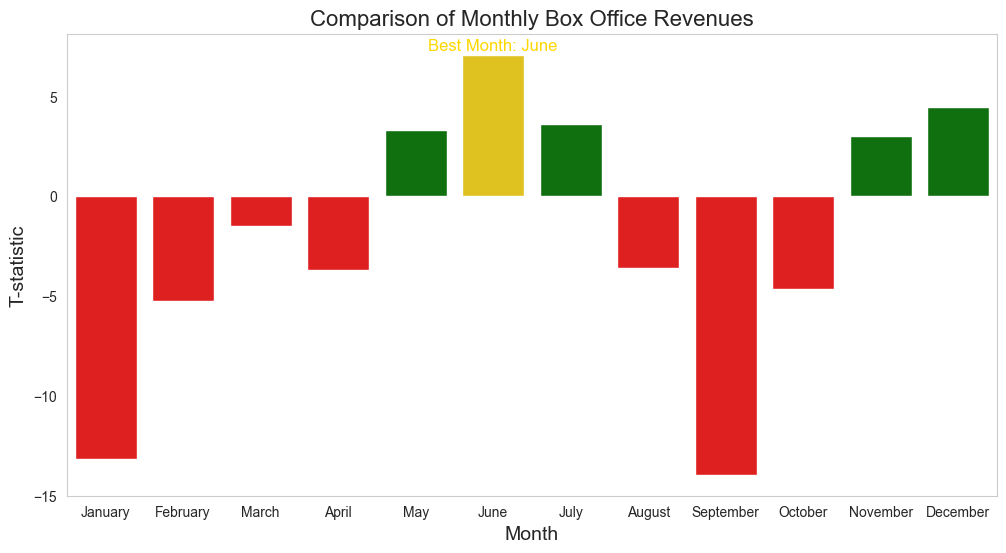

In [53]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='month_name',
    y='t_statistic',
    data=t_test_results_df,
    palette=['red' if x < 0 else 'gold' if t_test_results_df.loc[i, 'month'] == best_month else 'green' 
             for i, x in enumerate(t_test_results_df['t_statistic'])]
)

# Set the title and labels
ax.set_title('Comparison of Monthly Box Office Revenues', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('T-statistic', fontsize=14)

# Adding the annotation for the best month
best_t_stat = t_test_results_df.loc[t_test_results_df['month'] == best_month, 't_statistic'].iloc[0]
ax.annotate(f'Best Month: {best_month_name}', xy=(best_month_name, best_t_stat),
            xytext=(best_month_name, best_t_stat+0.2),  # Offset position of the text
            ha='center',  # Center the text horizontally
            fontsize=12, color='gold')
plt.grid(False)

# Show the plot
plt.show()

#### Monthly Box Office Analysis Summary :

- Our analysis identifies **June** as the prime month for movie releases, with **December** following closely behind. This trend is likely influenced by summer and end-of-year holiday seasons, periods when movie-going is traditionally more popular due to vacations.

- The t-test comparison across months confirms that June, coinciding with summer vacations, exhibits the highest positive difference in box office revenues. Similarly, December benefits from the festive **Noel holiday season**, making it the second most lucrative month for film debuts.

- These insights suggest that timing movie releases to coincide with major vacation periods can significantly enhance box office performance.


### Having discerned the significant monthly patterns in box office revenue, with June and December standing out as peak periods, we now pivot our focus to a more granular scale. The daily analysis will delve into the question of whether specific days of the week influence box office success. This step could unveil daily trends that might sharpen the strategic timing of movie releases

#### 3- Daily Analysis

###### **Data Preparation and Encoding**

In [46]:
# Encoding days of the week and genres
encoded_days = pd.get_dummies(movies_revenues['day_week']).astype(int)
genre_binarizer = MultiLabelBinarizer()
encoded_genres = genre_binarizer.fit_transform(movies_revenues['genres'])
encoded_genres_df = pd.DataFrame(encoded_genres, columns=genre_binarizer.classes_)

# Combining encoded features with revenue data
combined_data = pd.concat([movies_revenues['Movie_box_office_revenue'], encoded_days, encoded_genres_df], axis=1)
combined_data['day_week'] = movies_revenues['day_week']  # Including original day names for mean analysis

###### **Calculation of Average Revenue per Day and Genre**

In [47]:
# DataFrame for storing average revenue per day and genre
average_revenue = pd.DataFrame(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], columns=genre_binarizer.classes_)
for day in average_revenue.index:
    for genre in average_revenue.columns:
        genre_day_data = combined_data[(combined_data[day] == 1) & (combined_data[genre] == 1)]
        average_revenue.at[day, genre] = genre_day_data['Movie_box_office_revenue'].mean()

# Filling NaN values with zero
average_revenue.fillna(0, inplace=True)

###### **Best Release Day Analysis for Each Genre**

In [48]:
# Dictionaries for storing best release days
best_days_rf = {}  # Best days as per Random Forest model
best_days_mean = {}  # Best days as per mean analysis
best_days_final = {}  # Final selected best days
discrepancies = []  # Genres with discrepancies between models

# Analyzing best release day for each genre
for genre in encoded_genres_df.columns:
    genre_specific_data = combined_data[combined_data[genre] == 1]
    features = genre_specific_data[encoded_days.columns]
    target = genre_specific_data['Movie_box_office_revenue']

    # Mean analysis for best day
    best_day_mean_analysis = average_revenue[genre].idxmax()
    best_days_mean[genre] = best_day_mean_analysis

    # Random Forest model analysis
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
    random_forest_model.fit(features, target)
    feature_importances = random_forest_model.feature_importances_
    best_day_rf = encoded_days.columns[feature_importances.argmax()]
    best_days_rf[genre] = best_day_rf

    # Selecting the final best day and tracking discrepancies
    if best_day_rf == best_day_mean_analysis:
        best_days_final[genre] = best_day_rf
    else:
        discrepancies.append(genre)
        best_days_final[genre] = best_day_mean_analysis

# Reporting discrepancies
print("Genres with discrepancies between models:", discrepancies)

Genres with discrepancies between models: ['Comedy', 'Horror', 'Mystery', 'Romance', 'Science Fiction']


###### **Heatmap Visualization of Average Revenue and Best Release Days**

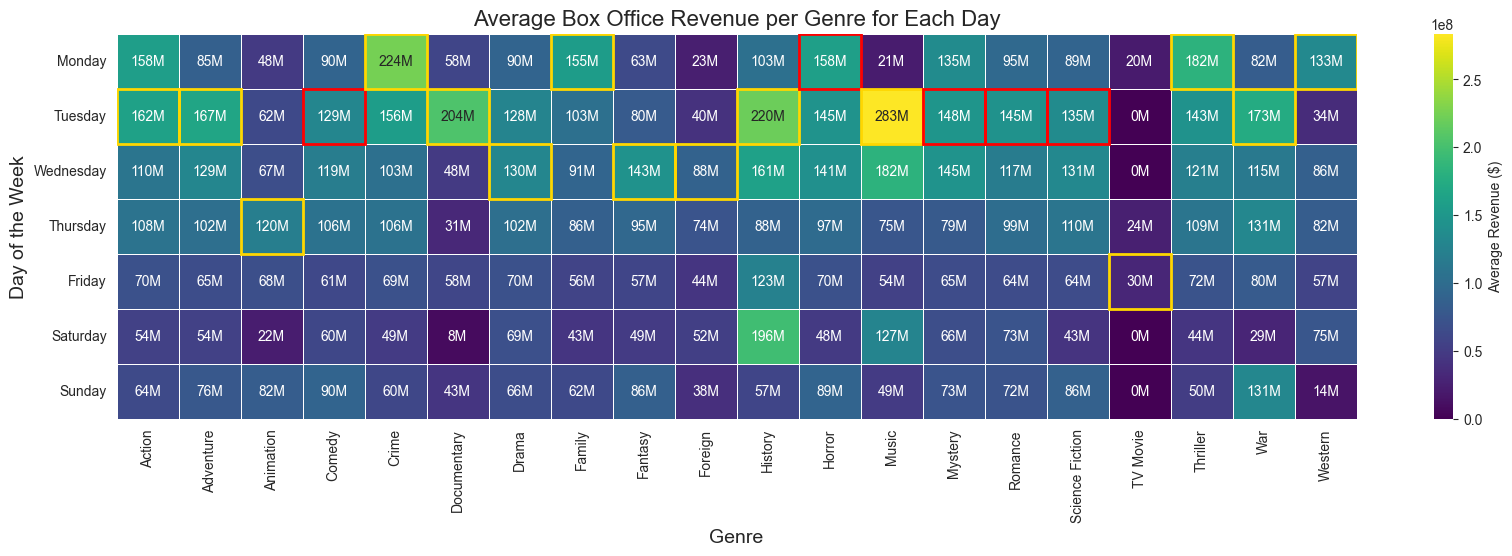

In [52]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Convert the revenue numbers into the 'M' format.
def millions(x, pos):
    return '{}M'.format(int(x*1e-6))

# Create the heatmap for the averages revenues per day per genre
plt.figure(figsize=(20, 5))
ax = sns.heatmap(average_revenue, annot=True, fmt=".1f", linewidths=.5, cmap='viridis',
                 cbar_kws={'label': 'Average Revenue ($)'})

# Update the annotation with the 'M'.
for text in ax.texts:
    text.set_text(millions(float(text.get_text().replace('−', '-')), None))

# Annotations for best release days
for genre in genre_binarizer.classes_:
    best_day = best_days_final[genre]
    day_index = days.index(best_day)
    genre_index = list(genre_binarizer.classes_).index(genre)
    ax.add_patch(plt.Rectangle((genre_index, day_index), 1, 1, fill=False, edgecolor="red" if genre in discrepancies else "gold", lw=2))

# Updating layout for better readability
# Setting the title and labels
ax.set_title('Average Box Office Revenue per Genre for Each Day', fontsize=16)
ax.set_xlabel('Genre', fontsize=14)
ax.set_ylabel('Day of the Week', fontsize=14)

plt.show()

#### Daily Box Office Revenue Analysis Summary:

- In our analysis, we systematically processed and examined the box office revenue data across different days of the week for various movie genres. We started by encoding the days and genres into a machine-readable format using one-hot encoding, which transformed categorical data into numerical. This enabled us to apply a Random Forest regression model to estimate the relative importance of each day of the week for the box office success of movies within each genre.

- Additionally, we conducted a mean revenue analysis to observe the average box office earnings by genre for each day. The comparison of findings from the Random Forest model and the mean revenue analysis occasionally revealed differences. In such cases, we leaned on the mean revenue figures as the more reflective measure of historical performance.

- The culmination of our analysis was presented in a heatmap, which intuitively displayed the average revenues, allowing for a quick visual assessment of the best release days per genre. This comprehensive approach ensured a robust and data-driven strategy for identifying the optimal days for movie releases, tailored to the nuances of genre-specific audience behaviors.

## Summary of Box Office Revenue Analysis
- In our comprehensive analysis, we investigated how the timing of a movie's release influences its box office success, considering yearly trends, monthly patterns, and daily fluctuations.

### Yearly Trends
- Our findings indicate a slight but consistent trend where more recent movies tend to earn marginally lower revenues when adjusted for inflation, hinting at evolving market dynamics within the film industry.

### Optimal Months for Movie Releases
- The analysis pinpoints **June** as the optimal month for movie releases, closely followed by **December**. This pattern can be attributed to the increased audience turnout during the summer and winter holiday seasons, respectively.

### Daily Box Office Performance
- A granular examination of daily box office revenues, segmented by movie genres, was conducted using both a Random Forest regression model and a mean revenue analysis. In instances of discrepancy between the two methods, the mean revenue analysis, which directly reflects historical performance, was deemed more reliable.

- The insights culminate in a heatmap visualization that succinctly depicts average revenues, facilitating a quick visual grasp of the most lucrative release days per genre. This strategic, data-driven approach is designed to optimize release schedules in alignment with genre-specific audience preferences.


# Sub-Question 2: Relationship between movie genres and its success

In [34]:
# Separate the array of genres in every movie then group by the genres
movies_by_genre = movies.explode('genres').groupby('genres')

Let's start by first analysing the distribution of the movies genres

In [35]:
# Count the number of movies per genre then sort it
genre_count = movies_by_genre['Movie_name'].count().sort_values(ascending=False).reset_index()
genre_count = genre_count.rename(columns={'Movie_name': 'Movie Count'})
genre_count

,genres,Movie Count
0,Drama,13552
1,Comedy,8515
2,Thriller,5024
3,Romance,4951
4,Action,4710
5,Crime,3084
6,Horror,2994
7,Adventure,2585
8,Science Fiction,2101
9,Family,1950


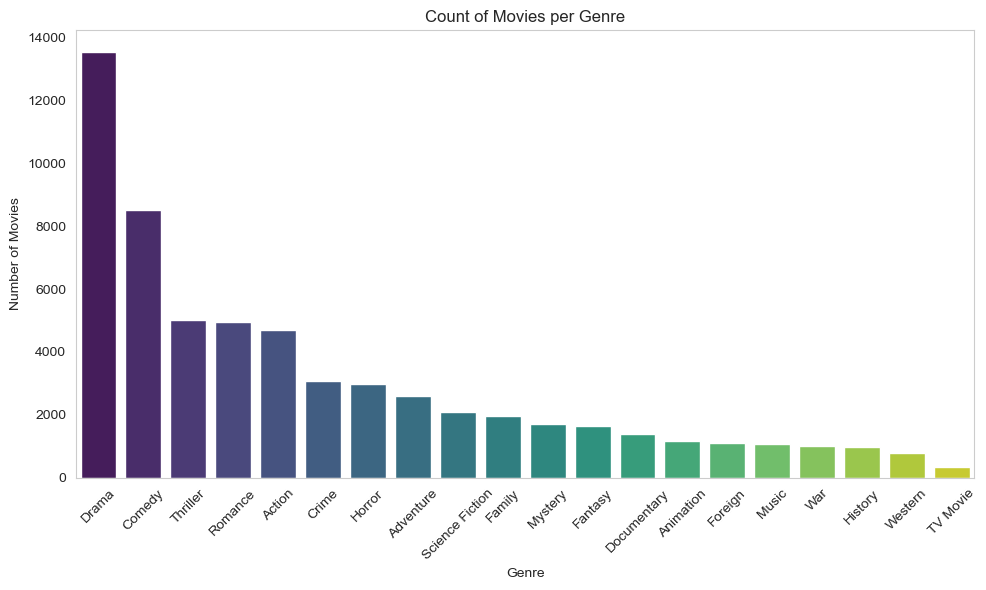

In [36]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.barplot(x='genres', y='Movie Count', data=genre_count, palette='viridis')
plt.title('Count of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

We can observe the distribution of movies across various genres. Among these genres, Drama emerges as the most prevalent, with an extensive count of 13,551 movies, suggesting its dominance in the dataset. It's closely followed by Comedy (8,515), Thriller (5,024), Romance (4,950), and Action (4,709), indicating their significant presence. Conversely, genres like TV Movie (335), Western (784), History (965), and War (1,007) have notably fewer movies, indicating a lesser representation within this dataset.

Genres with higher counts may denote broader appeal, while those with lower counts might cater to more niche audiences.
This set the question are the higher counts genres have the higher revenues ?

In [37]:
# Calculate the mean box office revenue per genre and then sort it
genre_revenue = movies_by_genre['Movie_box_office_revenue'].mean().sort_values(ascending=False).reset_index()
genre_revenue = genre_revenue.rename(columns={'Movie_box_office_revenue': 'Box Office mean revenue (in Millions $)'})

# Divide the revenue by 1 million
genre_revenue['Box Office mean revenue (in Millions $)'] /= 10 ** 6

genre_revenue

,genres,Box Office mean revenue (in Millions $)
0,Animation,254.909185
1,Adventure,205.765210
2,Fantasy,196.037049
3,Family,186.793312
4,Science Fiction,151.141377
5,Action,131.023402
6,War,119.485345
7,Thriller,95.637521
8,History,89.560320
9,Music,87.433772


The mean box office revenue by genres unveils intriguing insights about the financial performance of different genres within the dataset. While genres like Drama emerge as the most abundant, their average box office revenue of 32.56 million dollars indicates a moderate financial performance. In contrast, genres like Animation and Adventure display not only considerable movie counts but also boast significantly higher mean box office revenues of 140.94 million dollars and 125.00 million dollars respectively.

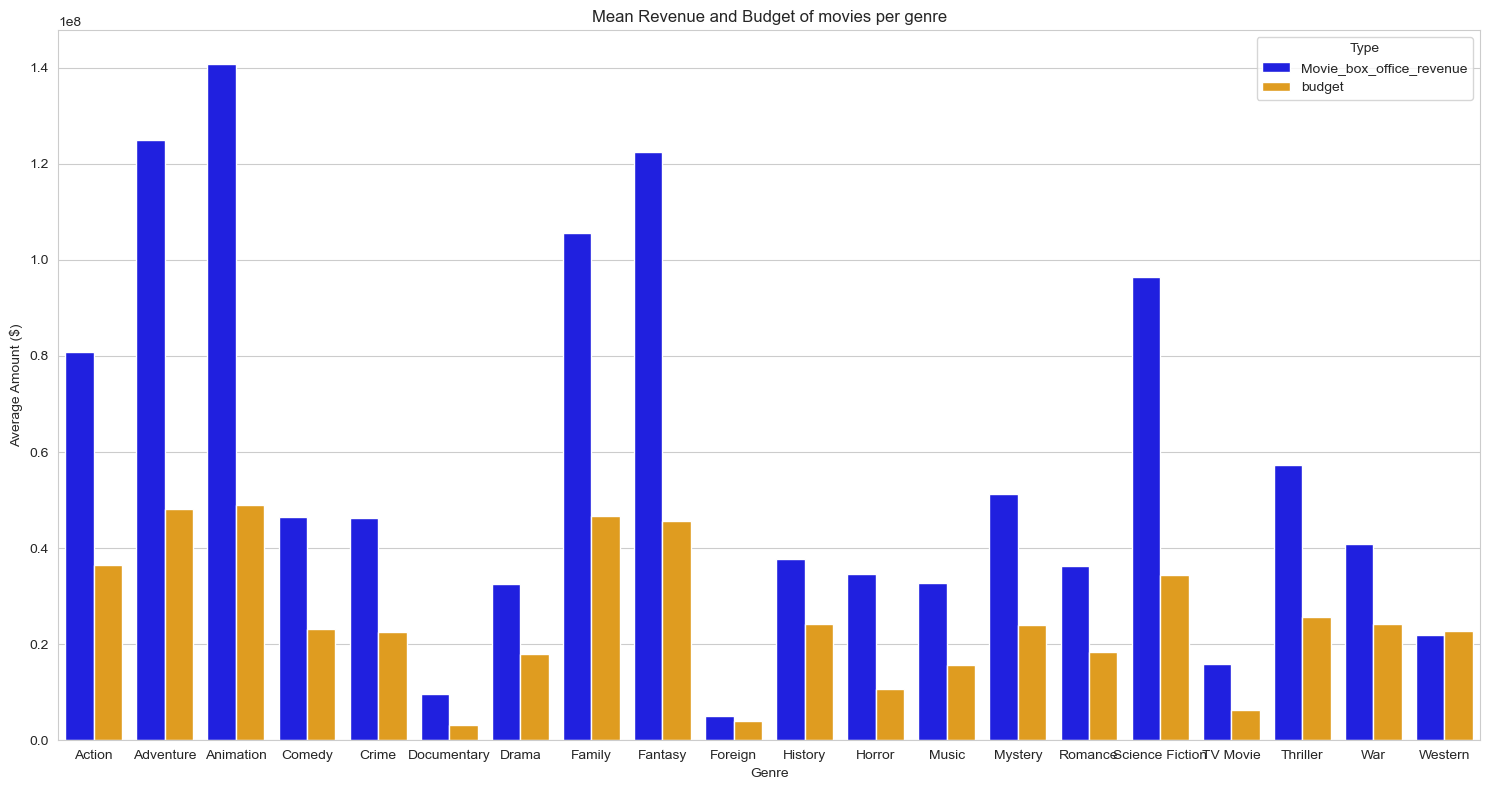

In [157]:
# Expand the genres of every movie to plot statistics
revenues = movies.explode('genres')[['genres', 'Movie_box_office_revenue']]
budget = movies.explode('genres')[['genres', 'budget']]

# Calculate mean values per genre
revenues_mean = revenues.groupby('genres').mean().reset_index()
budget_mean = budget.groupby('genres').mean().reset_index()

# Merge 'revenues_mean' and 'budget_mean' DataFrames for combined plotting
combined_data = pd.merge(revenues_mean, budget_mean, on='genres')

# Reshape the data to have a 'value' column for 'Movie_box_office_revenue' and 'budget'
combined_data = combined_data.melt(id_vars='genres', var_name='type', value_name='amount')

plt.figure(figsize=(15, 8))

# Plot mixed bar plot for mean revenue and mean budget per genre
sns.barplot(x='genres', y='amount', hue='type', data=combined_data, palette=['blue', 'orange'])
plt.title('Mean Revenue and Budget of movies per genre')
plt.xlabel('Genre')
plt.ylabel('Average Amount ($)')
plt.legend(title='Type', loc='upper right')

plt.tight_layout()
plt.show()

Lastly, let's try to analyze if the movies with the highest revenues are they the most profitable?

In [40]:
# Calculate the mean net profit of movies per genres and sort it in descending order
genre_profit = movies_by_genre['Net profit'].mean().sort_values(ascending=False).reset_index()
genre_profit = genre_profit.rename(columns={'Net profit': 'Box Office mean profit (in Millions $)'})

# Divide the profit by 1 million
genre_profit['Box Office mean profit (in Millions $)'] /= 10 ** 6

genre_profit

,genres,Box Office mean profit (in Millions $)
0,Animation,279.470976
1,Family,212.877900
2,Adventure,194.395337
3,Fantasy,184.152811
4,War,131.534246
5,Science Fiction,124.876039
6,Action,117.675261
7,Music,109.400852
8,Romance,82.204777
9,Thriller,79.776789


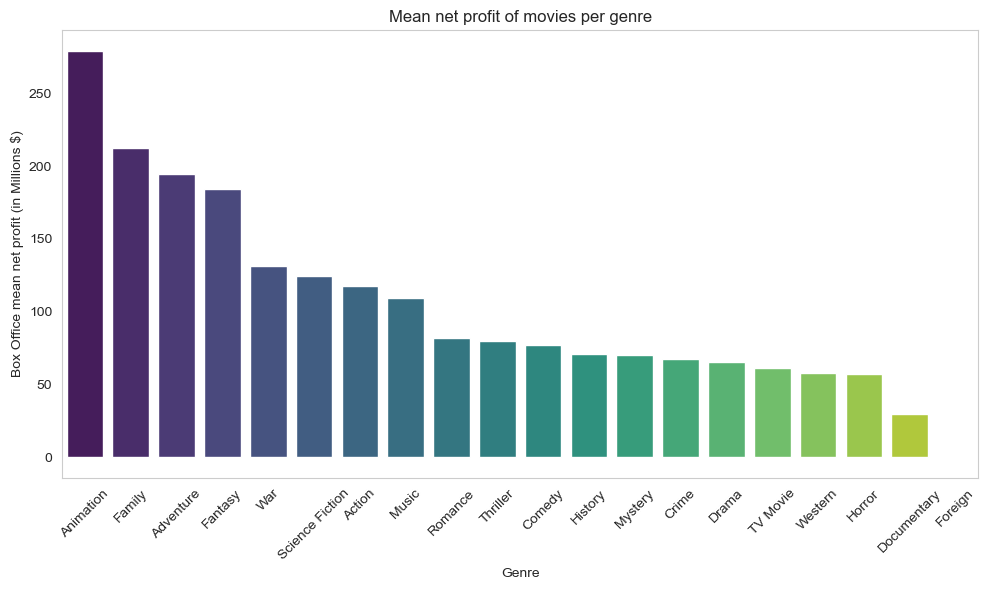

In [41]:
# Create a net profit plot
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.barplot(x='genres', y='Box Office mean profit (in Millions $)', data=genre_profit, palette='viridis')
plt.title('Mean net profit of movies per genre')
plt.xlabel('Genre')
plt.ylabel('Box Office mean net profit (in Millions $)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

The disparity observed between mean box office revenue and mean net profit across various movie genres reveals intriguing insights when considering movie budgets. Genres like Animation and Adventure exhibit higher mean box office revenues than their respective mean net profits by +2.20 million dollars and +9.44 million dollars respectively. Conversely, genres like Family and Science Fiction display a reverse trend, indicating mean net profits surpassing mean box office revenues by -8.71 million dollars and +17.20 million dollars respectively.

In [42]:
# Perform one-hot encoding on the 'genres' column
genres_encoded = movies.explode('genres')['genres'].str.get_dummies(', ').groupby(level=0).sum()
merged_data = pd.concat([genres_encoded, movies['Net profit']], axis=1)

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

correlation_matrix['Net profit']

Action             0.054112
Adventure          0.171193
Animation          0.156460
Comedy            -0.041112
Crime             -0.040330
Documentary       -0.024639
Drama             -0.096286
Family             0.146964
Fantasy            0.108656
Foreign           -0.029857
History           -0.016711
Horror            -0.045816
Music              0.012087
Mystery           -0.024963
Romance           -0.019082
Science Fiction    0.042886
TV Movie          -0.001621
Thriller          -0.029397
War                0.027425
Western           -0.017720
Net profit         1.000000
Name: Net profit, dtype: float64

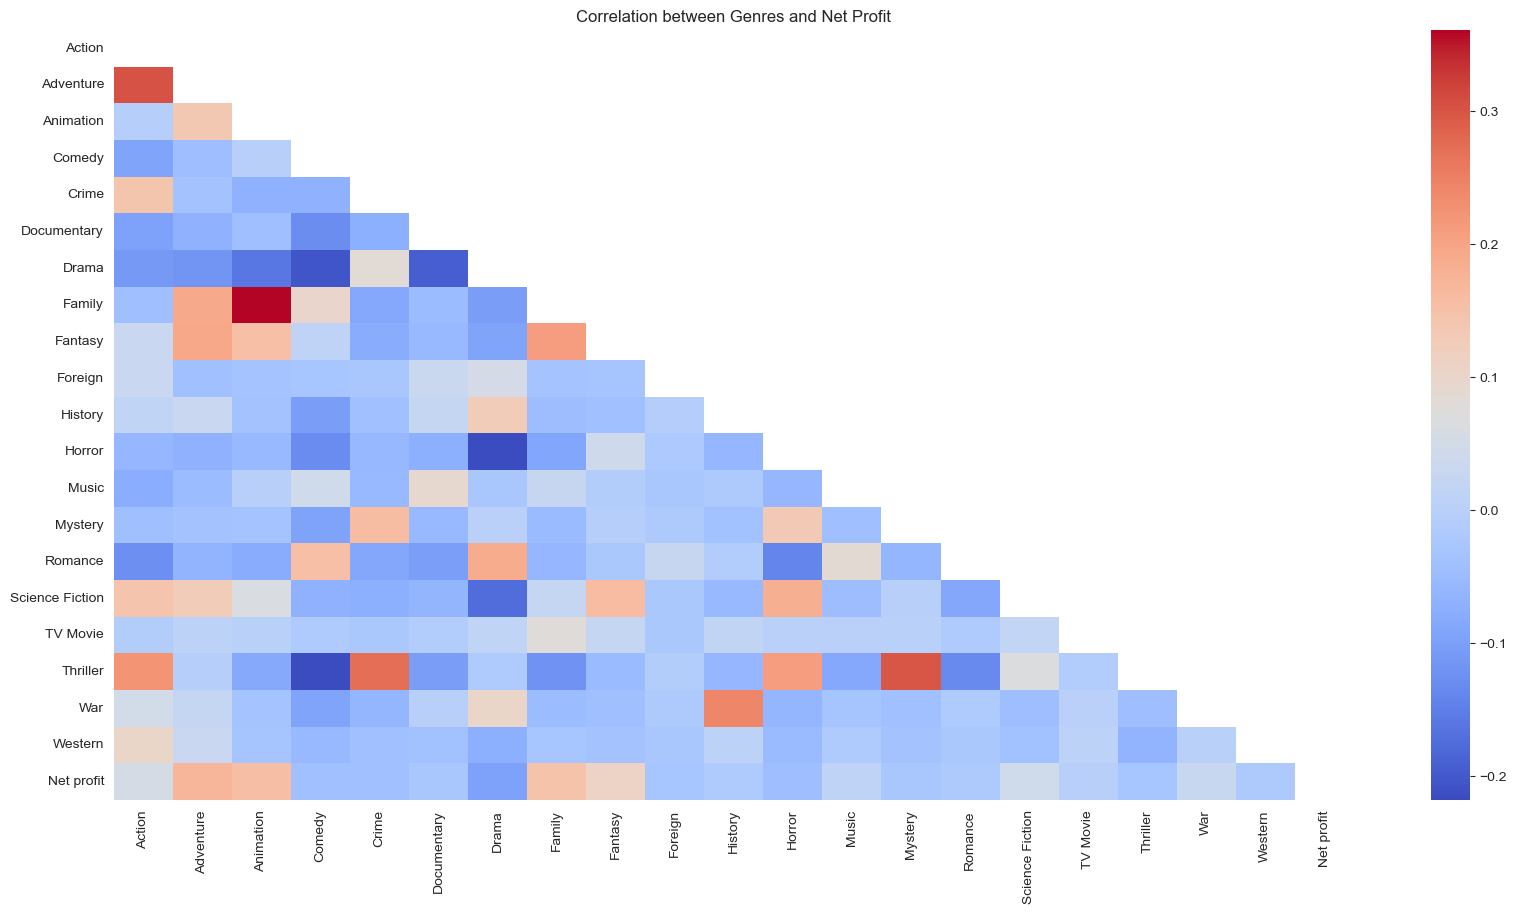

In [43]:
# Plot the correlation heatmap
plt.figure(figsize=(20, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Genres and Net Profit')
plt.grid(False)
plt.show()

The analysis of correlations between movie genres and net profit reveals intriguing associations.

Genres such as Adventure (0.237), Animation (0.160), Family (0.169), Fantasy (0.153), and Science Fiction (0.081) exhibit positive correlations with net profit. These positive correlations suggest a tendency for movies in these genres to yield higher net profits, indicating a potential commercial advantage.

On the contrary, genres like Drama (-0.152), Horror (-0.062), Mystery (-0.019), and Romance (-0.040) display negative correlations with net profit. These negative correlations imply that movies belonging to these genres might, on average, yield lower net profits. However, it's crucial to note that correlation does not establish causation; other factors may influence these relationships.

This leads to an intriguing avenue of exploration: the potential impact of blending multiple genres on a movie's net profit. How might the mix of genres influence the financial performance of a movie ?

/var/folders/my/z865vhpd7nq1j64xqjllt3f00000gn/T/ipykernel_1046/3670578825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_genres_profit['num_genres'] = nb_genres_profit['genres'].apply(lambda x: len(x))
/Users/izellale/opt/anaconda3/envs/data_science/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


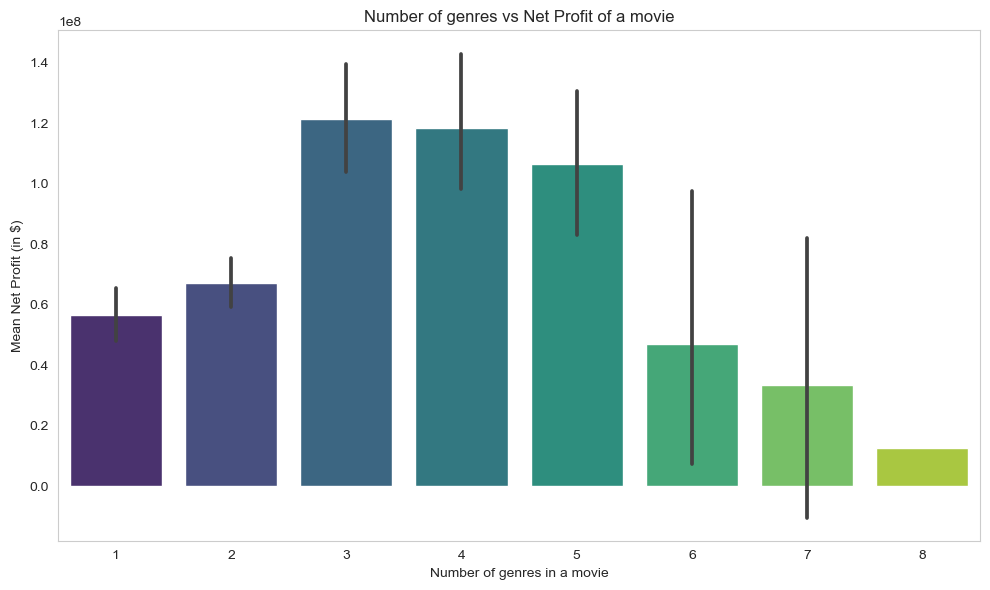

In [44]:
nb_genres_profit = movies[['genres', 'Net profit']]
nb_genres_profit['num_genres'] = nb_genres_profit['genres'].apply(lambda x: len(x))
nb_genres_profit = nb_genres_profit[nb_genres_profit['num_genres'] > 0]

plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')

sns.barplot(x='num_genres', y='Net profit', data=nb_genres_profit, palette='viridis')

plt.title('Number of genres vs Net Profit of a movie')
plt.xlabel('Number of genres in a movie')
plt.ylabel('Mean Net Profit (in $)')
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

Trend in Net Profit vs. Number of Genres:

Upon initial observation, there is a discernible pattern in the relationship between the number of genres associated with a movie and its net profit. An ascending trend in net profit is evident as the number of genres per movie increases from one to five. This trend indicates a positive association, suggesting that movies encompassing a broader range of genres tend to yield higher average net profits.

However, beyond the inclusion of five genres per movie, the trend takes an unexpected turn, showcasing a decline in net profit. This reversal suggests a possible saturation point or diminishing returns associated with an excessive number of genres. It raises the possibility that using an extensive array of genres might introduce challenges affecting a movie's commercial success.

Exploring Return on Investment (ROI) Across Genres:

Building upon these observations, an intriguing avenue for further analysis arises: What is the return on investment (ROI) of each genre?

Analyzing the ROI within each genre might provide deeper insights into the financial performance of movies based on different genre classifications. This analysis could show whether certain genres yield higher returns relative to their investment, contributing to a comprehensive understanding of the profitability of diverse genres in the film industry.

In [45]:
# Filter only movies with reasonable return on investment (ROI)
genre_roi =  movies.explode('genres')[['genres', 'ROI']]
genre_roi = genre_roi[genre_roi['ROI'] < 100]
genre_roi['ROI'] *= 100

# Analysis only on genres with at least 10 ROI values 
genre_roi = genre_roi.groupby('genres').filter(lambda x: len(x) > 10)

In [46]:
# Analysis only on genres with at least 10 ROI values 
roi = genre_roi.groupby('genres')['ROI'].mean().sort_values(ascending=False).reset_index()
roi['ROI'] = roi['ROI'].apply(lambda n: f"{n:.2f}%")

roi

,genres,ROI
0,Documentary,678.92%
1,Horror,422.69%
2,Music,388.69%
3,Animation,386.76%
4,War,329.67%
5,Romance,321.87%
6,Western,309.67%
7,Family,303.27%
8,Adventure,291.87%
9,Drama,270.29%


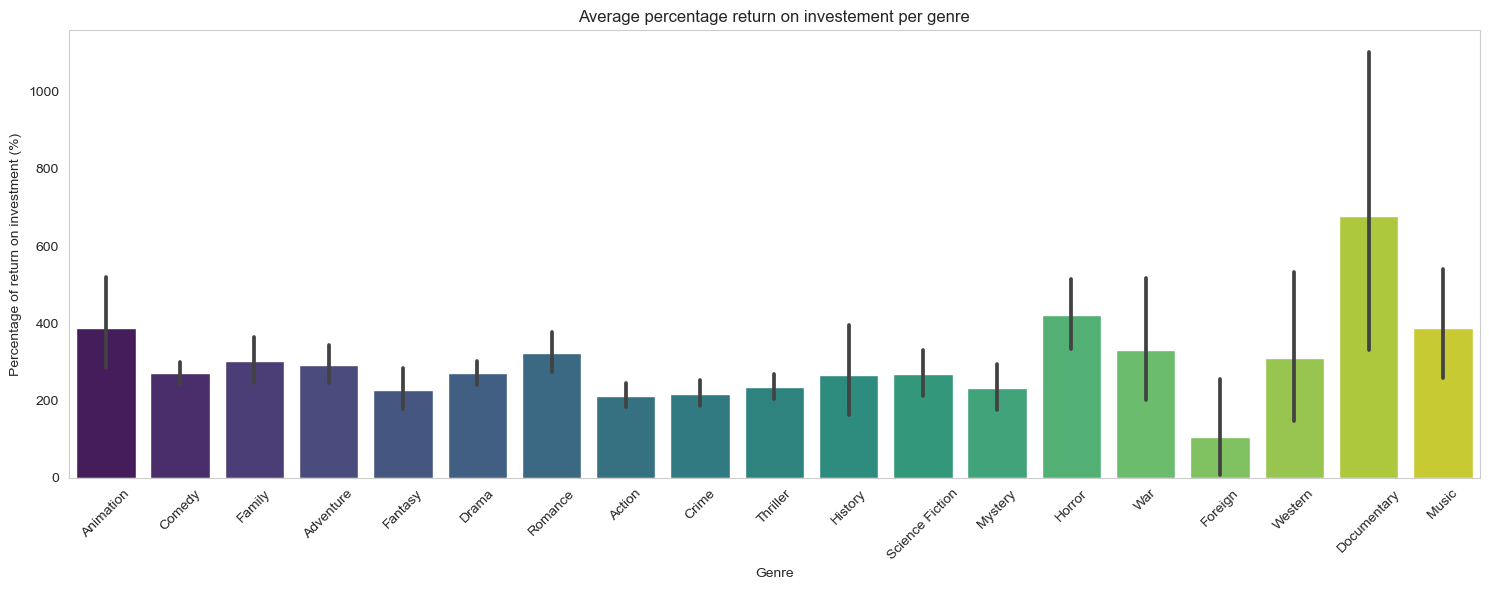

In [47]:
# Create a ROI plot
plt.figure(figsize=(15, 6))
sns.set_style('whitegrid')

sns.barplot(x='genres', y='ROI', data=genre_roi, palette='viridis')

plt.title('Average percentage return on investement per genre')
plt.xlabel('Genre')
plt.ylabel('Percentage of return on investment (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(False)

# Show the plot
plt.show()

Our exploration of movie genres, unveiling diverse insights into their impact on success metrics. Starting with mean revenue analyses revealed varied financial landscapes across genres, showcasing potential commercial strengths within specific cinematic classifications. Comparative revenue and budget assessments hinted at financial efficiency and potential correlations between investment and returns.

Analyzing net profits within genres showed profitability patterns, portraying gains and potential losses inherent to different genres. Correlation matrices highlighted relationship between genres and financial success metrics, unveiling potential inclinations towards profitability or financial challenges within specific genres.

However, the analysis of movie's success is not limited only to genres. Beyond these classifications, what other intricate attributes - storytelling, direction, cast, marketing, and audience reception - interweave to shape a movie's success?

# Sub-Question 3: Explore the relationship between movie plot sentiment and movie success

Through this sub-question, we want to explore the links between the feelings expressed in film summaries and the success of films. This part is based on a sentiment analysis of movies plots using NLP. We would like to address two main questions that are:

- Are movies that have emotional plot (either positive or negative) more successful than movies with neutral plot?

- Focusing on movies with emotional plot, what emotion (positive or negative) in the plot makes the movie more successful?


The success of movies is measured in terms of box office revenues and the definition of plot sentiment will be provided in the subsection dedicated to the NLP pipeline.

First let us consider the data available for this analysis.

In [35]:
# Drop nan in movies plot and box office revenues

movies_copy = movies.dropna(subset=['Movie_plot', 'Movie_box_office_revenue']).copy()
print(f'The number of movies available for this analysis is {len(movies_copy)}.')

The number of movies available for this analysis is 8217.


We have more than 8'000 movies with data available on their plot and box office revenue. This should be sufficient to start our analysis.

## NLP pipeline

Let us dive into the NLP part and get hands dirty. We first create the NLP pipeline.

In this part we have to tokenize movies plot as first step. From plot tokens, we can perform the sentiment analysis using `vaderSentiment.vaderSentiment` and its seniment analyser `SentimentIntensityAnalyzer()`. The latter returns for each sentence of tokens a polarity score measuring how positive/negative the sentence is. As sentiment threshold, we used the value +/- 0.05 as recommended in the lab sessions i.e. if the compound of the polarity score is greater than +0.05 the sentence is labeled as positive, if it is smaller than -0.05 the sentence is labeled as negative. For any score between -0.05 and +0.05 the sentence is consiedered as neutral.

Concerning the plot sentiment, we used the following procedure to label whether a plot sentiment is positive, negative, or neutral:
- if the plot contains 50% or more positive sentences, it is labeled as a positive emotions plot: 'Positive'
- if the plot contains more than 50% of negative sentences, it is labeled as a negative emotions plot: 'Negative'
- if the plot contains more than 50% of neutral sentences, it is labeled as a neutral plot: 'Neutral'
- if none of the previous conditions are fullfiled, we do not provide any label to the plot (i.e. the plot class is NaN)

This labeling technique should prevent ties in the plot emotion classification.

In [36]:
analyzer = SentimentIntensityAnalyzer()

In [37]:
def sentiment_evalution(plot):
    """
    Function that aims to analyse plot sentiments by examining each sentence of the plot.
    
    Input:  
    - plot: list of the tokens of a movie plot
    
    Output: 
    - sentence_score: list containing the polarity score of each plot sentence 
    - plot_class: string value containing the plot class (either 'Positive', 'Negative', 'Neutral' or nan)

    """

    sentence_class, sentence_score = [], []

    # Loop through all the sentences
    for sentence in plot: 

        sentence_score.append(analyzer.polarity_scores(sentence)['compound'])

        # Positive sentence
        if sentence_score[-1]>= 0.05:
            sentence_class.append(1)

        # Negative sentence
        elif sentence_score[-1] <= -0.05:
            sentence_class.append(-1)
        
        # Neutral sentence
        else:
            sentence_class.append(0)
        
    plot_class = classify_plot(sentence_class)
    
    return pd.Series([sentence_score, plot_class])


In [38]:
def classify_plot(plot_sentence_class):
    """
    Function that aims to classify the plot of a movie into a sentiment class. If 50% of the plot sentences
    belongs to the same sentiment class, this sentiment class is assigned as class of the plot.
    
    Input:  
    - plot_sentence_class: list of sentiment class of the plot sentences
    
    Output:
    - plot_class: string value containing the plot class (either 'Positive', 'Negative' or 'Neutral')

    """

    classes = np.array(plot_sentence_class)
    
    # Positive plot
    if sum(classes==1)/classes.size>=0.5:
        plot_class = 'Positive'

    # Negative plot
    elif sum(classes==-1)/classes.size>0.5:
        plot_class = 'Negative'

    # Neutral plot
    elif sum(classes==0)/classes.size>0.5:
        plot_class = 'Neutral'

    else:
        plot_class = np.nan
        
    return plot_class

In [39]:
# 1. Tokenize movies plot

movies_copy['Movie_plot_token'] = movies_copy['Movie_plot'].apply(lambda t: tokenize.sent_tokenize(t))

# 2. Get polarity scores of plot sentences and get plot classes

movies_copy[['Plot_sentence_score', 'Plot_class']] = movies_copy['Movie_plot_token'].apply(sentiment_evalution)

# 3. Compute mean score of plot sentences

movies_copy['Plot_mean_score'] = movies_copy['Plot_sentence_score'].apply(np.mean)

Here the column `Plot_sentence_score` contains for each plot a list of the sentences score indicating how positive/negative these sentences are. `Plot_mean_score` contains the mean of plot sentences scores. `Plot_class` contains the label of the plot and has 4 different classes `Positive`, `Negative`, `Neutral` or NaN. The classes are assigned according to the procedure mentionned previously. 

We can print the 5 first movies of the resulting dataset to see the new columns.

In [40]:
movies_copy.head()

,Freebase_Movie_ID,imdb_id,Movie_name,release_date,year,month,day_week,genres,spoken_languages,Movie_languages,...,ROI,popularity,Movie_runtime,vote_average,vote_count,Movie_plot,Movie_plot_token,Plot_sentence_score,Plot_class,Plot_mean_score
0,/m/0dyb1,tt0114709,Toy Story,1995-10-30,1995,10,Monday,"[Animation, Comedy, Family]",[English],[English Language],...,11.065291,21.946943,77.0,7.7,5415.0,Woody is a pull-string cowboy doll and leader...,[ Woody is a pull-string cowboy doll and leade...,"[0.0, 0.0, 0.743, -0.4767, -0.2023, 0.0, 0.0, ...",NaN,0.059784
1,/m/09w353,tt0113497,Jumanji,1995-12-15,1995,12,Friday,"[Adventure, Fantasy, Family]","[English, Français]","[French Language, English Language]",...,3.043035,17.015539,104.0,6.9,2413.0,"In 1869, two boys bury a game board in a fore...","[ In 1869, two boys bury a game board in a for...","[0.0, 0.3612, -0.7351, -0.4939, 0.1779, -0.296...",Negative,-0.198138
2,/m/0676dr,tt0113228,Grumpier Old Men,1995-12-22,1995,12,Friday,"[Romance, Comedy]",[English],"[Italian Language, English Language]",...,NaN,11.712900,101.0,6.5,92.0,The lifelong feud between Max and John has c...,[The lifelong feud between Max and John has ...,"[-0.296, 0.4019, 0.5267, 0.0, -0.5994, 0.0, 0....",NaN,-0.035131
3,/m/03vny7,tt0114885,Waiting to Exhale,1995-12-22,1995,12,Friday,"[Comedy, Drama, Romance]",[English],[English Language],...,4.090760,3.859495,121.0,6.1,34.0,Waiting to Exhale is a story about four Africa...,[Waiting to Exhale is a story about four Afric...,"[0.6369, 0.8126, 0.7003, -0.6124, 0.5859, 0.49...",Positive,0.382900
4,/m/094g2z,tt0113041,Father of the Bride Part II,1995-02-10,1995,2,Friday,[Comedy],[English],[English Language],...,NaN,8.387519,106.0,5.7,173.0,George Banks must accept the reality of what h...,[George Banks must accept the reality of what ...,"[0.3818, -0.2023, 0.2732, -0.2732]",Positive,0.044875


We have now performed the processing part on movies plot. We can start to work with these processed data available to us. The following steps for this sentiment analysis part will be:
- Visualize the data
- Perform a naive analysis to answer our two questions on plot sentiment and succes
- Perform a rigorous analysis to address our two questions on plot sentiment and success

## Visualization

To get a better undestanding of our NLP pipeline work and start our analysis on plot emotions, we can start with several visualizations. Let us see the distribution of polarity scores of one of the plot.

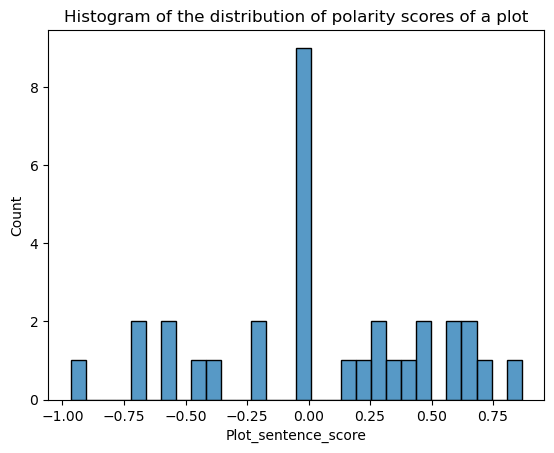

In [41]:
# Plot distribution of sentences scores for the plot of the first movie

hist_plot = sns.histplot(data=movies_copy.iloc[0], x = 'Plot_sentence_score',  bins=30)
hist_plot.set_title("Histogram of the distribution of polarity scores of a plot")
plt.show()

We can also plot the overall counts of plot emotions to get insight on the distribtion. Neutral plot are classified as non emotional (`False`) while positve and negative plots are considered as emotional (`True`).

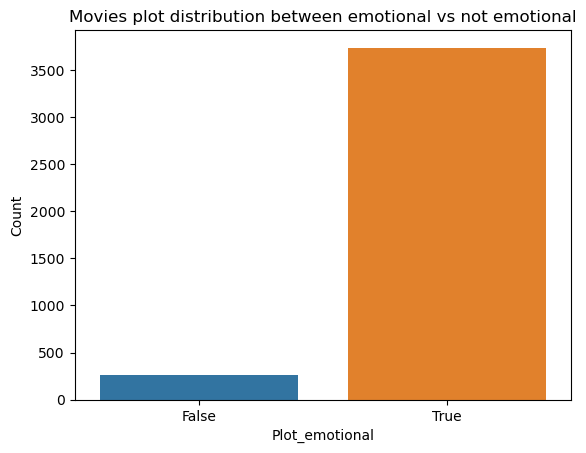

In [42]:
# Drop missing values of 'Plot_class' and create the new column
movies_copy['Plot_emotional'] = movies_copy.dropna(subset=['Plot_class'])['Plot_class'].apply(
    lambda x: True if x in ['Negative', 'Positive'] else False
    )

# Count the occurrence of each boolean value
value_counts = movies_copy['Plot_emotional'].value_counts()

# Create a DataFrame from the counts
plot_data = pd.DataFrame({'Plot_emotional': value_counts.index, 'Count': value_counts.values})

# Create the barplot
plt.title('Movies plot distribution between emotional vs not emotional')
sns.barplot(x='Plot_emotional', y='Count', data=plot_data)
plt.show()

Now we simply plot the distribution of movie plot emotions for the 10 most common genres to get insight of the differences that may occur between the different genres. We think that the plot emotion of a movie might depend on the genre of the movie.

In [43]:
# Get the top 10 of most common genres
movies_full_genre = movies_copy.explode('genres')
top10_genre = movies_full_genre['genres'].value_counts()[:10]

movies_top10_genre = movies_full_genre[movies_full_genre['genres'].isin(top10_genre.index)]

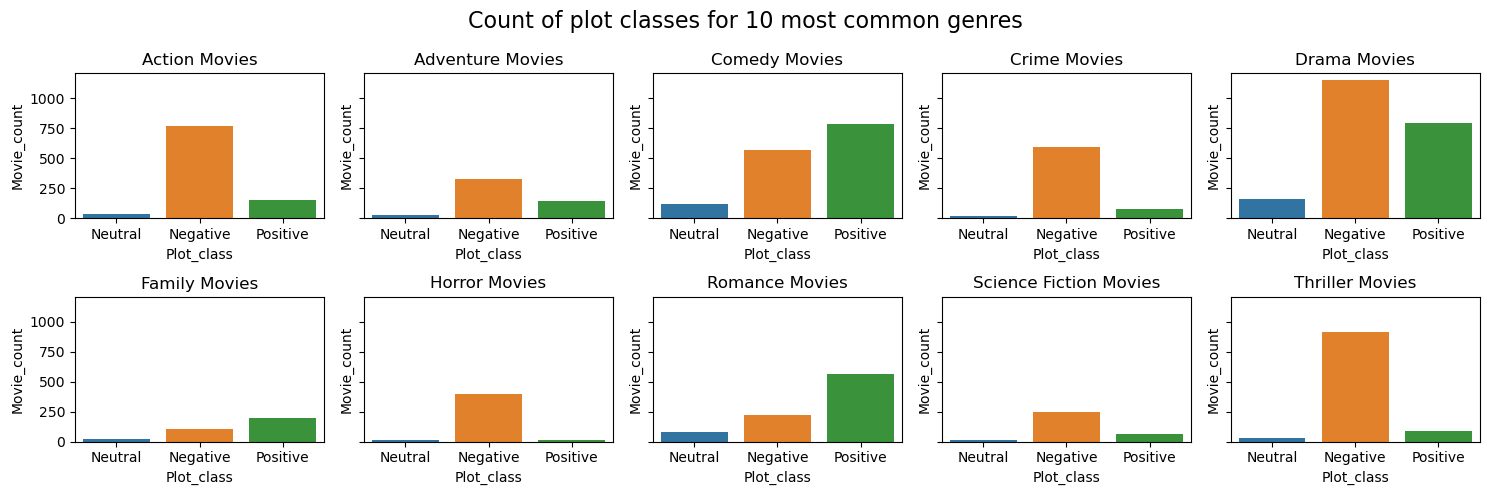

In [44]:
# Group the data frame by genre
genre_grouped = movies_top10_genre.groupby(['genres', 'Plot_class']).size().unstack(fill_value=0)

# Set figure parameters
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharey=True)
fig.suptitle('Count of plot classes for 10 most common genres', fontsize=16)
order = ['Neutral', 'Negative', 'Positive']

# Plot 10 most common first genres
for idx, genre in enumerate(genre_grouped.index):
    sns.barplot(ax = axes[idx//5, idx%5], data = genre_grouped[genre_grouped.index==genre], order=order)
    axes[idx//5, idx%5].set_title(genre+" Movies")
    axes[idx//5, idx%5].set_ylabel('Movie_count')

fig.tight_layout()

Indeed it seems that the count of plot emotions changes from one genre to another particularly when looking at the distribution of positve vs negative plots. After this visualization exercise, we can initiate a naive preliminary analysis as the counts do not provide information on movies success. Afterwards, we will preform a more rigourous analysis to address our initial questions.

## Naive analysis

### Question 1: Success of movies with emotional plot vs non-emotion plot

A quick reminder, for this part neutral movies plot are considered as non-emotional plot (i.e. `Plot_emotional` is `False`) while plot labelled as positive/negative are considered as emotional plot  (i.e. `Plot_emotional` is `True`).
The measure of the success in our analysis is the box office revenue, so first we visualize the box office revenues for movies with emotional versus non-emotional plot.

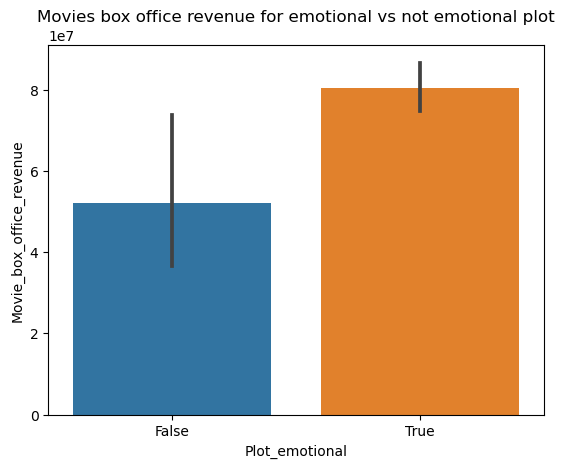

In [45]:
# Plot distribution of movies box office revenues for emotional plot vs not emotional

plt.title('Movies box office revenue for emotional vs not emotional plot')
sns.barplot(x='Plot_emotional', y='Movie_box_office_revenue', data=movies_copy)
plt.show()

As naive analysis, we can perform a t-test to see whether the difference of mean between the two distributions is statistically significant.

In [46]:
# Extract box office revenues for both plot types
emotional_movies = movies_copy[movies_copy['Plot_emotional']==True]['Movie_box_office_revenue']
not_emotional_movies = movies_copy[movies_copy['Plot_emotional']==False]['Movie_box_office_revenue']

# Perform t-test to determine p_value
test_stat, p_value = stats.ttest_ind(emotional_movies, not_emotional_movies)

print(f'The test statistic is {test_stat:.3} and the p_value is {p_value:.3}.')

The test statistic is 2.32 and the p_value is 0.0202.


The conclusion of this naive analysis is that we can reject the null hypothesis stating that the two sets of movies box office revenues have identical means (at a significance level of .05) as the p-value (0.0202) is below the significance level. We can say that the mean of box office revenues for movies with emotional plots is higher than for movies with non-emotional plots as the mean difference is statistically significant and the t-statistic is positive. 

### Question 2: Success of movies with positive plot vs negative plot

We now focus on movies that have an emotional plot. We wish to know whether movies with positive and negative emotional plot have a difference of success in terms of box office revenues. We now perform the same analysis as before but comparing box office revenues for positive emotional plots versus negative ones.

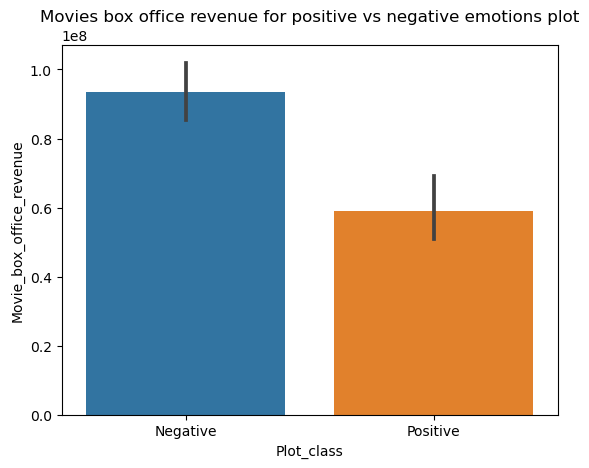

In [47]:
# Plot distribution of box office revenues for positive vs negative emotions plot

emotional_movies_df = movies_copy[movies_copy['Plot_emotional']==True]

plt.title('Movies box office revenue for positive vs negative emotions plot')
sns.barplot(data = emotional_movies_df, order=['Negative', 'Positive'], x='Plot_class', y='Movie_box_office_revenue')
plt.show()

As naive analysis, we can perform a t-test to see whether the difference of means between the two distributions is statistically significant.

In [48]:
# Extract box office revenues for movies with positive and negative plots

positive_plot_movies = emotional_movies_df[emotional_movies_df['Plot_class']=='Positive']['Movie_box_office_revenue']
negative_plot_movies = emotional_movies_df[emotional_movies_df['Plot_class']=='Negative']['Movie_box_office_revenue']

# Perform t-test to determine p_value
test_stat, p_value = stats.ttest_ind(negative_plot_movies, positive_plot_movies)

print(f'The test statistic is {test_stat:.3} and the p_value is {p_value:.3}.')

The test statistic is 5.35 and the p_value is 9.18e-08.


Once again the conclusion of this naive analysis is that we can reject the hypothesis that the two sets of movies box office revenues have identical means (at a significance level of .05) as the p-value (9.18e-08) is below the significance level. We can say that the mean of box office revenues for movies with a negative emotional plot is higher than for movies with positive emotional plots as the mean difference is statistically significant and the t-statistic is positive. 

## Rigorous analysis

 As good data scientists that attend ADA course, we know that we must pay attention to confounders when doing such analysis. This is the reason why we now perform a more rigorous analysis to address our research questions on sentiment influence on movies success and see whether our previous observations are right.

### Question 1: Success of movies with emotional plot vs non emotion plot | Matched experience

For this research question we perform matching on genres and movie budget to have a fair comparison and remove confounders. We consider that the genre of a movie might have an effect on whether the plot is sentimental or not. For example, we would expect to have a higher number of emotional plots for drama and maybe only a few emotional plots for action movies. This may impact our analysis on box office revenues if we do not perform matching as the two genres may not have similar distributions of box office revenues. 
This is why, in our analysis, the treatment group (movies with emotional plots) has the exact same number of movies as the control group (movies with non-emotional plots) for each genre.

We also consider budgets as a confounder: it is obvious that if we consider the money generated as output, we have to care about the money at the input i.e. the budget as the later has probably a big impact on the revenues. A movie with a higher budget will generally reach a bigger audience (higher budget means it will probably lead to a greater marketing, be translated into more languages, have better special effects...) and consequently generate a higher box office revenue.

In [52]:
# Explode dataframe on genres column
movies_full_genre = movies_copy.explode('genres')
movies_full_genre.reset_index(inplace=True)

To start our matching, we group movies into two categories for each genre: movies with emotional plot (treatment) and movies with non-emotional plot (control).

In [53]:
# Group movies by genres for matching
genre_grouped_movies = movies_full_genre.groupby('genres')

idx_emotional_movies = {}
idx_non_emotional_movies = {}

# Extract indices of movies plot with emotions and no emotions in plot
for genre, genre_df in genre_grouped_movies:

    # Get indicices of emotional/non-emotional plot
    idx_emotional_movies[genre] = genre_df[genre_df["Plot_emotional"]==True].index
    idx_non_emotional_movies[genre] = genre_df[genre_df["Plot_emotional"]==False].index

    # Number of movies available
    print(f'Genre {genre} - Number of movies with emotional plot: {len(idx_emotional_movies[genre])}\
           - Number of movies with non-emotional plot: {len(idx_non_emotional_movies[genre])}')

Genre Action - Number of movies with emotional plot: 915           - Number of movies with non-emotional plot: 38
Genre Adventure - Number of movies with emotional plot: 464           - Number of movies with non-emotional plot: 26
Genre Animation - Number of movies with emotional plot: 120           - Number of movies with non-emotional plot: 5
Genre Comedy - Number of movies with emotional plot: 1349           - Number of movies with non-emotional plot: 114
Genre Crime - Number of movies with emotional plot: 668           - Number of movies with non-emotional plot: 21
Genre Documentary - Number of movies with emotional plot: 39           - Number of movies with non-emotional plot: 16
Genre Drama - Number of movies with emotional plot: 1945           - Number of movies with non-emotional plot: 156
Genre Family - Number of movies with emotional plot: 294           - Number of movies with non-emotional plot: 23
Genre Fantasy - Number of movies with emotional plot: 247           - Number 

To match the dataset on budgets, it is very unlikely that two movies have the exact same budget. So, we will match movies between the treatment group and the control group whose diffence in budget is not more than 20% of the smallest one i.e. $\text{abs}(\text{budget movie}_{treat} - \text{budget movie}_{control}) < 0.2*min(\text{budget movie}_{treat}, \text{budget movie}_{control})$.

In [54]:
# Storage of matched movies indices
matched_movies_genre = defaultdict(lambda: [])

# Match treatment and control on genre and budget
for genre in idx_emotional_movies.keys():

    for no_emotion_idx in idx_non_emotional_movies[genre]:
        for emotion_idx in idx_emotional_movies[genre]:

            # Matching for budget
            budget1 = movies_full_genre.iloc[emotion_idx]["budget"]
            budget2 = movies_full_genre.iloc[no_emotion_idx]["budget"]
            if (no_emotion_idx not in matched_movies_genre[genre]) and \
                    abs(budget1 - budget2)<np.min([budget1, budget2])*0.2:
                matched_movies_genre[genre].append(emotion_idx)
                matched_movies_genre[genre].append(no_emotion_idx)
                break

We can now group all matched indices to retrieve the matched dataset:

In [55]:
# Retrieve matched dataset
matched_dataframe = pd.concat([movies_full_genre.iloc[matched_movies_genre[genre]] for genre, _ in genre_grouped_movies])

print(f'The size of the matched dataset is {len(matched_dataframe)}.')

The size of the matched dataset is 538.


Now that we have a matched dataset, we can perform our statistical test:

In [56]:
# Matched movies with emotional plot
movies_emotional_plot = matched_dataframe[matched_dataframe["Plot_emotional"] == True]

# Matched movies with non-emotional plot
movies_non_emotional_plot = matched_dataframe[matched_dataframe["Plot_emotional"] == False]

# Perform t-test
test_stat, p_value = stats.ttest_ind(movies_emotional_plot["Movie_box_office_revenue"], 
                                           movies_non_emotional_plot["Movie_box_office_revenue"])

print(f'The test statistic is {test_stat:.3} and the p_value is {p_value:.3}.')

The test statistic is 0.838 and the p_value is 0.402.


The conclusion of this rigorous analysis for question 1 is that we cannot reject the null hypothesis stating that the movies box office revenues for the treatment and control group have identical means (at a significance level of .05) as the p-value (0.402) is above the significance level. Thus, we cannot infer that the difference between the means is significant.

As we can see the matching leads to a different conclusion than what we had for the naive analysis. We can understand the importance of removing confounders such as movies budget.

We can visualize the resulting box office revenues distribution:

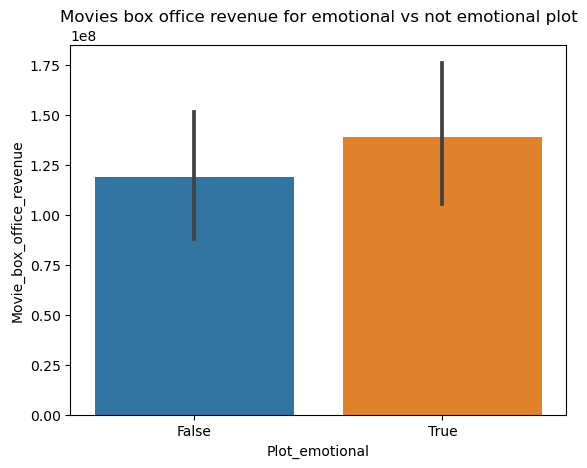

In [57]:
# Plot distribution of movies box office revenues for emotional plot vs not emotional

plt.title('Movies box office revenue for emotional vs not emotional plot')
sns.barplot(x='Plot_emotional', y='Movie_box_office_revenue', data=matched_dataframe)
plt.show()

We observe that the distribution of movies box office revenues is similar for both kind of movies plot as the confidence intervals are overlapping over a great portion. It seems that after matching it is likely that the distribution of box office revenues for movies with emotional plot is similar to the one of movies with non-emotional plot. At least, we cannot reject the fact that their means are similar.

### Question 2: Success of movies with positive plot vs negative plot | Matched experience

For this question, as for the previous one, we can consider movies budget and genre as confounders and we have to match movies with similar budget and genre together. Our treatment group are the set of movies with negative emotional plot while the control group is the set of movies with positive emotional plot.

Let us start by grouping movies by genre and separate movies with positive emotional plot from negative emotional plot.

In [59]:
# Group movies by genres for matching
genre_grouped_movies = movies_full_genre.groupby('genres')

idx_positive_movies = {}
idx_negative_movies = {}

# Extract indices of treatment and control group
for genre, genre_df in genre_grouped_movies:

    # Get indicices of positve/negative plot
    idx_positive_movies[genre] = genre_df[genre_df["Plot_class"]=='Positive'].index # Control
    idx_negative_movies[genre] = genre_df[genre_df["Plot_class"]=='Negative'].index # Treatment

    # Number of movies available
    print(f'Genre {genre} - Number of movies with positive plot: {len(idx_positive_movies[genre])}\
           - Number of movies with negative plot: {len(idx_negative_movies[genre])}')

Genre Action - Number of movies with positive plot: 151           - Number of movies with negative plot: 764
Genre Adventure - Number of movies with positive plot: 141           - Number of movies with negative plot: 323
Genre Animation - Number of movies with positive plot: 55           - Number of movies with negative plot: 65
Genre Comedy - Number of movies with positive plot: 781           - Number of movies with negative plot: 568
Genre Crime - Number of movies with positive plot: 79           - Number of movies with negative plot: 589
Genre Documentary - Number of movies with positive plot: 28           - Number of movies with negative plot: 11
Genre Drama - Number of movies with positive plot: 795           - Number of movies with negative plot: 1150
Genre Family - Number of movies with positive plot: 193           - Number of movies with negative plot: 101
Genre Fantasy - Number of movies with positive plot: 88           - Number of movies with negative plot: 159
Genre Foreign 

Now we perform the matching on budget as in question 1).

In [60]:
# Storage of matched movies indices
matched_movies_genre = defaultdict(lambda: [])

# Match treatment and control on genre and budget
for genre in idx_negative_movies.keys():

    if len(idx_positive_movies[genre]) < len(idx_negative_movies[genre]):
        idx_set_1 = idx_positive_movies[genre]
        idx_set_2 = idx_negative_movies[genre]

    else:
        idx_set_1 = idx_negative_movies[genre]
        idx_set_2 = idx_positive_movies[genre]

    for movie_1_idx in idx_set_1:
        for movie_2_idx in idx_set_2:
        
            # Matching for budget 
            budget1 = movies_full_genre.iloc[movie_1_idx]["budget"]
            budget2 = movies_full_genre.iloc[movie_2_idx]["budget"]
            if (movie_2_idx not in matched_movies_genre[genre]) and \
                    abs(budget1 - budget2)<np.min([budget1, budget2])*0.2:
                matched_movies_genre[genre].append(movie_1_idx)
                matched_movies_genre[genre].append(movie_2_idx)
                break

In [61]:
# Group matched movies
matched_dataframe = pd.concat([movies_full_genre.iloc[matched_movies_genre[genre]] for genre, _ in genre_grouped_movies])

print(f'The size of the matched dataset is {len(matched_dataframe)}.')

The size of the matched dataset is 2378.


Now that we have a matched dataset, we can perform our statistical test:

In [62]:
# Matched movies with positve plot
movies_positive_plot = matched_dataframe[matched_dataframe["Plot_class"] == "Positive"]

# Matched movies with negative plot
movies_negative_plot = matched_dataframe[matched_dataframe["Plot_class"] == "Negative"]

# Perform t-test
test_stat, p_value = stats.ttest_ind(movies_positive_plot["Movie_box_office_revenue"], 
                                           movies_negative_plot["Movie_box_office_revenue"])

print(f'The test statistic is {test_stat:.3} and the p_value is {p_value:.3}.')

The test statistic is -2.14 and the p_value is 0.0324.


The conclusion of this rigorous analysis for question 2 is that we can reject the null hypothesis stating that the movie box office revenues of the treatment and control group have identical means (at a significance level of .05) as the p-value (0.0324) is below the significance level. We can say that the mean of box office revenues for movies with a negative emotional plot is higher than for movies with positive emotional plots as the mean difference is statistically significant and the t-statistic is negative.

As we can see the matching does not lead to a different conclusion than what we had for the naive analysis. This is interesting to observe that negative emotional generally convey a greater success looking at the box office revenues. One would probably have thought that humans would be more sensitive to movies with positive emotional plot rather than negative emotional ones. "The heart has its reasons which reason knows not." to quote the famous french mathematician Blaise Pascal.

We can visualize the resulting box office revenues distribution:

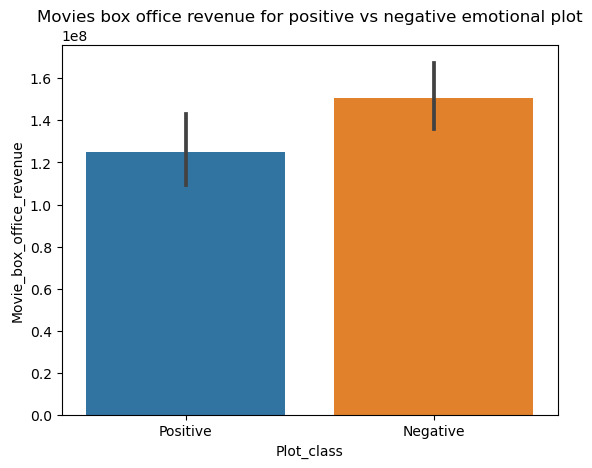

In [63]:
# Plot distribution of movie box office revenues for positive vs negative emotional plot

plt.title('Movies box office revenue for positive vs negative emotional plot')
sns.barplot(x='Plot_class', y='Movie_box_office_revenue', data=matched_dataframe)
plt.show()

We observe that the distribution of movies box office revenues seems to be different for the two types of plot as the confidence intervals are not overlapping (or just a little). It seems that after matching it is likely that the distribution of box office revenues for movies with negative emotional plot is not similar to the one of movies with positive emotional plot. Movies with negative emotional plot tends to have a higher box office revenue compared to movies with positive emotional plot and as stated before, this difference is statistically significant (at the 0.05 significance level).

We can say that the mean of box office revenues for movies with a negative emotional plot is higher than for movies with positive emotional plots as the mean difference is statistically significant and the t-statistic is positive. We draw the same conclusion as the one of our naive analysis, but this time we took care to remove confounders using a matched data set.

### Wrap up

To conclude this whole part on sentiment analysis of movies plot, let us wrap up the main discovery. From our first research question, it seems that there is no significant difference between the success of movies with emotional plot versus movies that have a non-emotional plot looking at the box office revenues. However, an intersting discovery is that when movies plot starts to deal with emotions, it appears that movies with negative emotional plot encounter a greater success in terms of box office revenues than movies with positive emotional plot. The difference of box office revenues is statistically significant at the 0.05 significance level. It seems that the audience tend to be more sensitive to plot that convey negative emotions such as sadness, shame or even anger.

## Sub-Question 4: Relationship between the casting of a movie and it's box office revenue.

### Data preparation

We will be working with the characters dataframe, let us see first how it looks like

In [32]:
display(characters)

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r
...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c
450665,913762,/m/03pcrp,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_
450666,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc
450667,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj


We are not going to use the Wikipedia movie id, so let us remove it.

In [33]:
characters = characters.drop('Wikipedia_Movie_ID', axis=1)

Let us take a closer look at our data by inspecting its missing values percentages.

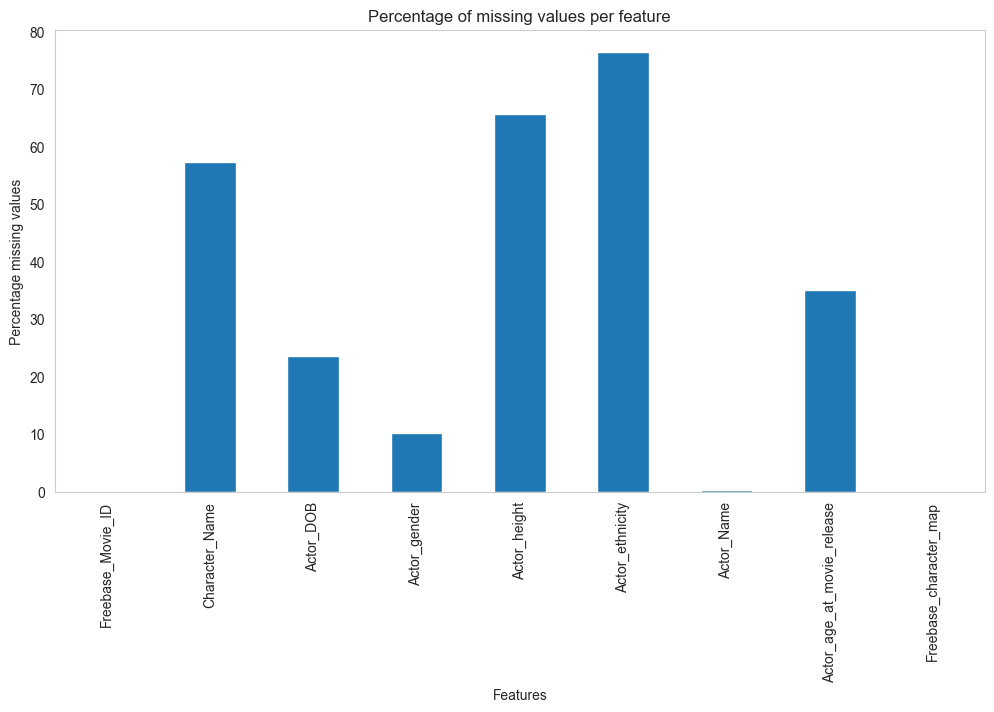

In [34]:
plot_nan(characters, 'Percentage of missing values per feature')


Let us take a look at the gender repartition among our dataset.

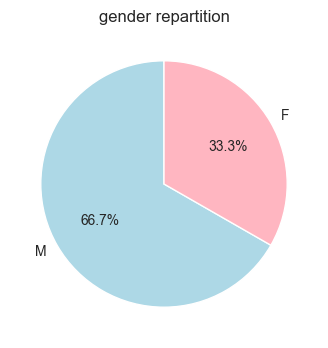

In [35]:
# Counting how many characters of each gender are there
gender_counts = characters['Actor_gender'].value_counts()

# Creating a pie chart
plt.figure(figsize=(4, 4))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightpink'])
plt.title('gender repartition')
plt.show()

Our study is going to focus on the relationship between many casting factors and the box office revenue of a movie. We see that the characters dataframe contains many informations that may be usefull for us. These information are related to the diversity of the casting of a movie, like the number of actors in the movie, the number of female actors, the number of ethnicities, the age of the actors, etc...
So let us extract these informations and save them for later. 

We can start by extracting the number of actors per movie and add this information to the movies dataframe.

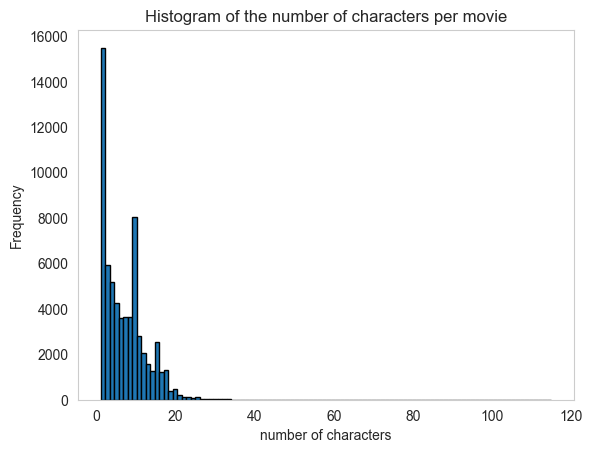

In [36]:
# Number of characters per each movie
characters_per_movie = characters.groupby('Freebase_Movie_ID').size()

# Plotting the distribution of the number of characters per movie
characters_per_movie.plot(kind='hist', bins=100, edgecolor='black')

plt.title('Histogram of the number of characters per movie')
plt.xlabel('number of characters')
plt.ylabel('Frequency')
plt.grid(False)

# Show the plot
plt.show()

In [37]:
# merging the number of characters per movie into movies dataframe 
characters_per_movie.name = 'number_of_actors'
movies = movies.merge(characters_per_movie, left_on="Freebase_Movie_ID", right_index=True)

In [38]:
movies.drop('release_date', inplace = True, axis=1)

In [39]:
actor_names = characters.groupby('Freebase_Movie_ID')['Actor_Name'].apply(list)
actor_names.name = 'actor_names'

In [40]:
movies = movies.merge(actor_names, left_on = "Freebase_Movie_ID", right_index =True)

Another usefull information we can extract from the characters dataframe is the number of female characters per movie.

In [41]:
female_characters = characters[characters['Actor_gender'] == 'F']
number_of_female_actors = female_characters.groupby('Freebase_Movie_ID').size()

In [42]:
number_of_female_actors.name = 'number_of_female_actors'
movies = movies.merge(number_of_female_actors, left_on="Freebase_Movie_ID", right_index=True)

We are also going to collect the number of ethnicities per movie.

In [43]:
number_of_ethnicities = characters.groupby('Freebase_Movie_ID')["Actor_ethnicity"].apply(
    lambda x: x.nunique()
)

In [44]:
number_of_ethnicities.name = "number_of_ethnicities"
movies = movies.merge(number_of_ethnicities, left_on = 'Freebase_Movie_ID', right_index=True)

Finally, we are going to collect the mean and the standard deviation of the age of the actors for each movie. The standard deviation of the age of the actors is collected because it can be a good indicator of the diversity of the casting.

In [45]:
mean_actor_age = characters.groupby('Freebase_Movie_ID')["Actor_age_at_movie_release"].mean()

In [46]:
mean_actor_age.name = "mean_actor_age"
movies = movies.merge(mean_actor_age, left_on = 'Freebase_Movie_ID', right_index=True)

In [47]:
var_actor_age = characters.groupby('Freebase_Movie_ID')["Actor_age_at_movie_release"].var()

In [48]:
var_actor_age.name = "var_actor_age"
movies = movies.merge(var_actor_age, left_on = 'Freebase_Movie_ID', right_index=True)

Finally, since our study will focus on the relationship between the casting of a movie and its box office revenue, we discard all movies who's box office revenue are missing.

In [49]:
movies.dropna(subset=['Movie_box_office_revenue'],inplace=True)

Since it is very unlikely that a movie has only one actor, we consider these movies as outliers in our dataset and wee discard them.

In [50]:
movies = movies[movies['number_of_actors'] >1]

In [51]:
display(movies)

,Freebase_Movie_ID,imdb_id,Movie_name,year,month,day_week,genres,spoken_languages,Movie_languages,Movie_countries,...,Movie_runtime,vote_average,vote_count,Movie_plot,number_of_actors,actor_names,number_of_female_actors,number_of_ethnicities,mean_actor_age,var_actor_age
0,/m/0dyb1,tt0114709,Toy Story,1995,10,Monday,"[Animation, Comedy, Family]",[English],[English Language],[United States of America],...,77.0,7.7,5415.0,Woody is a pull-string cowboy doll and leader...,13,"[John Ratzenberger, Tim Allen, Annie Potts, Do...",3,3,38.692308,310.730769
1,/m/09w353,tt0113497,Jumanji,1995,12,Friday,"[Adventure, Fantasy, Family]","[English, Français]","[French Language, English Language]","[United States of America, Japan]",...,104.0,6.9,2413.0,"In 1869, two boys bury a game board in a fore...",16,"[David Alan Grier, Robin Williams, Jonathan Hy...",6,4,31.000000,190.181818
2,/m/0676dr,tt0113228,Grumpier Old Men,1995,12,Friday,"[Romance, Comedy]",[English],"[Italian Language, English Language]",[United States of America],...,101.0,6.5,92.0,The lifelong feud between Max and John has c...,10,"[Katie Sagona, Walter Matthau, Kevin Pollak, D...",5,3,54.888889,623.111111
3,/m/03vny7,tt0114885,Waiting to Exhale,1995,12,Friday,"[Comedy, Drama, Romance]",[English],[English Language],[United States of America],...,121.0,6.1,34.0,Waiting to Exhale is a story about four Africa...,14,"[Whitney Houston, Angela Bassett, Loretta Devi...",6,2,32.928571,95.763736
4,/m/094g2z,tt0113041,Father of the Bride Part II,1995,2,Friday,[Comedy],[English],[English Language],[United States of America],...,106.0,5.7,173.0,George Banks must accept the reality of what h...,16,"[Steve Martin, Diane Keaton, Martin Short, Kim...",8,4,38.909091,175.690909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27364,/m/0bwhfgl,tt0061087,They're a Weird Mob,1966,8,Thursday,[Comedy],[English],[English Language],"[Australia, United Kingdom]",...,112.0,6.3,2.0,"Nino Culotta is an Italian immigrant, newly ar...",3,"[Walter Chiari, Chips Rafferty, Clare Dunne]",1,0,48.500000,112.500000
27374,/m/0d41pf,tt0139876,Basha,1995,1,Sunday,[Action],[தமிழ்],[Tamil Language],[India],...,NaN,7.8,14.0,Manikkam is an humble auto driver who helps p...,7,"[Janagaraj, Nagma, Raghuvaran, Rajnikanth, Vij...",1,3,39.000000,138.000000
27376,/m/0b7_8s,tt0479751,Sivaji: The Boss,2007,6,Thursday,"[Action, Comedy, Drama]","[தமிழ், తెలుగు]","[Hindi Language, Tamil Language, English Langu...",[India],...,184.0,6.9,25.0,"The film begins in medias res, with a masked p...",13,"[Cochin Haneefa, Shriya Saran, Rajnikanth, Sum...",2,4,46.700000,183.566667
27410,/m/05f4734,tt0120422,Up 'n' Under,1998,1,Friday,[Comedy],[],[],[United Kingdom],...,99.0,5.6,6.0,It followed the story of an inept pub team fro...,5,"[Ralph Brown, Gary Olsen, Richard Ridings, Nei...",1,1,35.800000,40.700000


We are left with 8499 movies which is enough for conducting our study

Furthermore, our characters dataset does not contain any information regarding the success of an actor. We would like to define an actor to be successfull if and only if he has been nominated for the oscars during his career. Note that this binary representation of actors is not very accurate since we do not take into account the number of nominations neither whether the actor won an oscar or not. To do so, we import a Kaggle dataset (https://www.kaggle.com/datasets/unanimad/the-oscar-award/). The dataset award contains all the nominated actors to the oscars between 1927 and 2023.

In [52]:
oscars = pd.read_csv('datasets/KAGGLE_dataset/the_oscar_award.csv')
display(oscars)

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10760,2022,2023,95,HONORARY AWARD,"To Euzhan Palcy, a masterful filmmaker who bro...",NaN,True
10761,2022,2023,95,HONORARY AWARD,"To Diane Warren, for her genius, generosity an...",NaN,True
10762,2022,2023,95,HONORARY AWARD,"To Peter Weir, a fearless and consummate filmm...",NaN,True
10763,2022,2023,95,GORDON E. SAWYER AWARD,Iain Neil,NaN,True


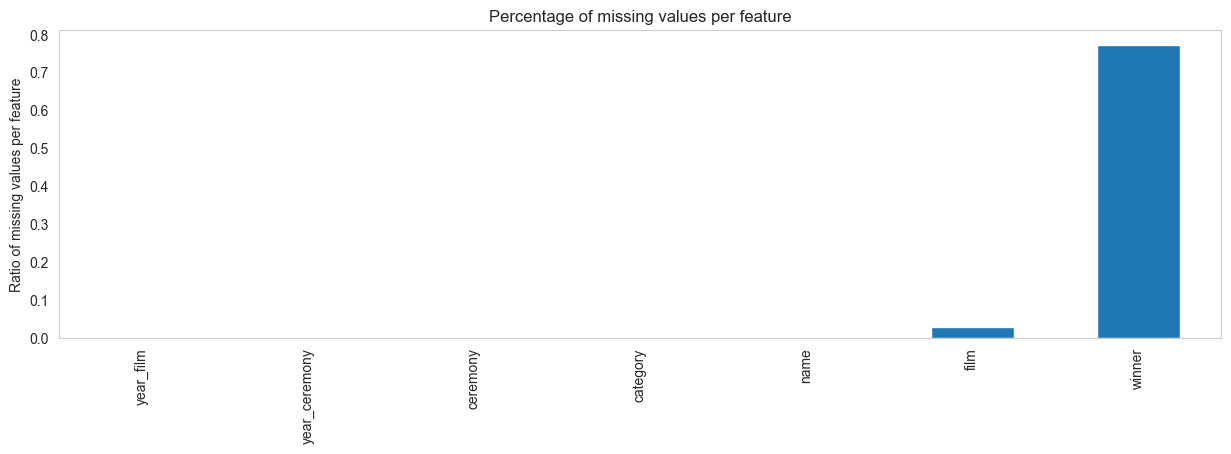

In [53]:
plot_missing_values_percentage(oscars)

In [54]:
# Filter characters to keep only the ones that have been nominated to the oscars.
oscar_characters = characters[characters['Actor_Name'].isin(oscars['name'])] 

# Since an actor can be nominated multiple times for an oscar, we call .unique() on the Actor_name column to extract the name of the actors that have been nominated to the oscars.
oscar_actors = oscar_characters['Actor_Name'].unique()

In [55]:
# Add a new column to the movies dataframe that is True if and only if the casting of the movie contains an oscar nominated actor.
movies['number_of_oscar_actors'] = movies['actor_names'].map(lambda x: number_of_oscar_actors(x, oscar_actors))
movies['has_oscar_actor'] = movies['number_of_oscar_actors'].map(lambda x: x>=1)

### Do successfull actors increase the box office revenues of a movie ?


#### 1. A naive analysis

We want to start by naively comparing the box office revenues between movies based on the number of oscar nomiated actors they have. Let us start by partitioning our dataset :

In [56]:
no_oscar_actor = movies[movies['number_of_oscar_actors'] == 0]
one_oscar_actor = movies[movies['number_of_oscar_actors'] == 1]
two_oscar_actor = movies[movies['number_of_oscar_actors'] == 2]
three_or_more_oscar_actor = movies[movies['number_of_oscar_actors'] >=3]

In [57]:
# computing the means 
zero_mean = no_oscar_actor['Movie_box_office_revenue'].mean()
one_mean = one_oscar_actor['Movie_box_office_revenue'].mean()
two_mean = two_oscar_actor['Movie_box_office_revenue'].mean()
three_or_more_mean = three_or_more_oscar_actor["Movie_box_office_revenue"].mean()

# computing the 95% confidence intervals for the means.
zero_ci = 1.96 * no_oscar_actor['Movie_box_office_revenue'].std() / np.sqrt(len(no_oscar_actor))
one_ci = 1.96 * one_oscar_actor['Movie_box_office_revenue'].std() / np.sqrt(len(one_oscar_actor))
two_ci = 1.96 * two_oscar_actor['Movie_box_office_revenue'].std() / np.sqrt(len(two_oscar_actor))
three_or_more_ci = 1.96 * three_or_more_oscar_actor['Movie_box_office_revenue'].std() / np.sqrt(len(three_or_more_oscar_actor))

# We use plotly for interactive graphs.
# Create the figure
fig = go.Figure()

# Add bar plots
categories = ['no nomination', 'one nomination', 'two nominations', 'three or more nominations']
means = [zero_mean, one_mean, two_mean, three_or_more_mean]
cis = [zero_ci, one_ci, two_ci, three_or_more_ci]
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']

for category, mean, ci, color in zip(categories, means, cis, colors):
    fig.add_trace(go.Bar(
        name=category,
        x=[category],
        y=[mean],
        error_y=dict(type='data', array=[ci], visible=True),
        marker_color=color
    ))

# Customize the layout
fig.update_layout(
    title='Comparison of Mean Box Office Revenue with Confidence Intervals',
    yaxis=dict(title='Mean Box Office Revenue'),
    showlegend=False
)
fig.write_html("./4-oscars-categories.html")
# Show the plot
fig.show()


We can see that as the number of oscar nominated actors increases, the movie box office revenues drastically increase accordingly. Let us maybe try to find the sweet spot for the number of oscar nominated actors you should have in your cast so that your box office revenues make the difference!

#### 2. A closer look at the data

Since we are not naive, and we are aware of the dangers of observational studies, let us take a closer look at our data. Let us compare the boc office revenues between movies who had at least one oscar nominated actor in their cast (the treatment) and movies who don't (control group). We will compare distributions between the control and the treatement group for features like the buget to see if they are balanced and we will try to balance such features between the groups if not.

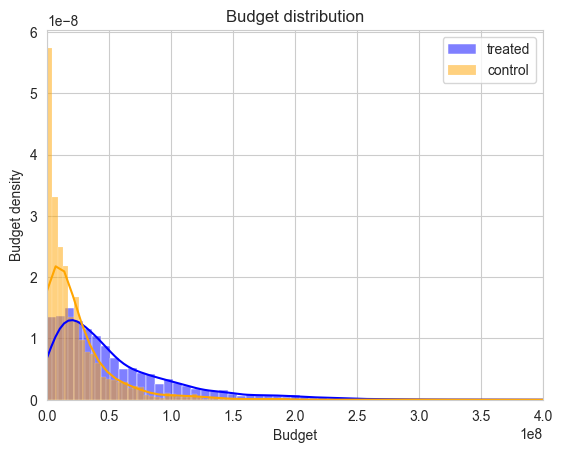

In [58]:
# budget of movies
treated = movies[movies['has_oscar_actor'] == True]
control = movies[movies['has_oscar_actor'] == False]
ax = sns.histplot(treated['budget'], stat='density', kde=True, color='blue', label='treated');
ax = sns.histplot(control['budget'], stat='density', kde=True, color='orange', label='control')
ax.set(title='Budget distribution',xlabel='Budget', ylabel='Budget density')
plt.legend()
plt.xlim(0,0.4e9)
plt.show()

# As we can observe from this plot, the budget variable is 
# quite unbiased between he two groups, the number of
# untreated movies that have a very low budget 
# is quite high, whereas treated movies have higher budgets.

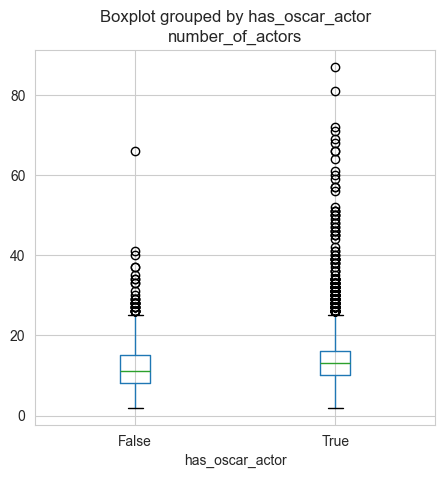

In [59]:
# Number of actors
movies.boxplot(by='has_oscar_actor', column='number_of_actors', figsize = [5, 5], grid=True)
plt.show()

# As we can see from this plot, treated movies and control movies are pretty
# balanced regarding the number of actors, however, treated movies tend to
# have more outliers than control movies.

As we can see, the budget field is quite unbalanced between the two groups, but intuitively, we would like to compare movies with similar budgets. There are other covariates that may influence whether the movie has a primed oscar actor like the number of actors, the genre of the movie, etc...  Let us hence do a one to one matching before taking any hazardous conclusions. The goal of the matching will be to balance these covariates across treated and untreated groups so that the only systematic difference between them is the presence of an Oscar-primed actor. This way, any difference in the outcome (box office revenue) can be more confidently attributed to the treatment effect.

The way we are going to do the matching is by means of propensity scores. Recall that propensity scores represent the probability of a movie receiving the treatement, here the oscar actor.

For practical purposes, we are going to consider movies genres as the first genre that appears in the list of movie_genres.

We will also consider only the movies budgets and number of actors when computing the propensity scores.

In [60]:
movies_study = movies.copy()
movies_study = movies_study[['Movie_box_office_revenue','budget','number_of_actors', 'has_oscar_actor']]

In [61]:
#Drop the movies with no budget
movies_study.dropna(subset = ['budget'], inplace = True)

In [62]:
# let's standardize the continuous features
movies_study['budget'] = (movies_study['budget'] - movies_study['budget'].mean()) /movies_study['budget'].std()
movies_study['number_of_actors'] = (movies_study['number_of_actors'] - movies_study['number_of_actors'].mean()) /movies_study['number_of_actors'].std()

In [63]:
movies_study['has_oscar_actor'] = movies_study['has_oscar_actor'].astype(int)

In [64]:
# Select the features for regression
X = movies_study.drop(['Movie_box_office_revenue','has_oscar_actor'], axis=1) 
y = movies_study['has_oscar_actor']

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Extract the estimated propensity scores
movies_study['Propensity_score'] = result.predict()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.533922
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        has_oscar_actor   No. Observations:                 4806
Model:                          Logit   Df Residuals:                     4803
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                  0.1081
Time:                        19:42:54   Log-Likelihood:                -2566.0
converged:                       True   LL-Null:                       -2877.0
Covariance Type:            nonrobust   LLR p-value:                8.988e-136
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.1887      0.041     28.757      0.000       1.108       1.270
budget     

For this task, we implement the simplest, full optimal matching, and analyse the results.

In order to perform matching between pairs, a distance/similarity function is needed. Since the library used for the matching (networkx) has a function that maximizes the sum of weights between pairs, it is natural to use a function that measures similarity.

Wanting to minimize the difference of propensity scores between pairs, we define the similarity function between two instances $x$ and $y$ like:

$$ similarity(x,y) = 1 - | propensity\_score(x) - propensity\_score(y) |$$
This function captures the difference in scores like a distance, but since the distance defined like that would always be between 0 and 1, subtracting it from 1 would be a meaningful measure to use for similarity. The function is implemented in  the utils.py file 

In [65]:
# Separate the control and the treated groups
treated_study = movies_study[movies_study['has_oscar_actor'] ==1]
control_study = movies_study[movies_study['has_oscar_actor'] ==0]

We perform the matching using perform_matching defined and described in utils.py

In [66]:
matching = perform_matching(control_study, treated_study)

In [67]:
# Grouping all the matched movies in a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [68]:
balanced_movies_study = movies.loc[matched]

In [69]:
treated = balanced_movies_study.loc[balanced_movies_study['has_oscar_actor'] == True] #People that attained the program
control = balanced_movies_study.loc[balanced_movies_study['has_oscar_actor'] ==False] #People that didn't attain the program

Let us now compare the box office revenues between the treatment and the control group.

In [70]:
treated.Movie_box_office_revenue.describe()

count    1.375000e+03
mean     9.127863e+07
std      2.314605e+08
min      1.698422e+00
25%      7.704933e+06
50%      3.328419e+07
75%      9.125232e+07
max      5.702985e+09
Name: Movie_box_office_revenue, dtype: float64

In [71]:
control.Movie_box_office_revenue.describe()

count    1.375000e+03
mean     7.844589e+07
std      2.695581e+08
min      2.813802e+00
25%      5.334468e+06
50%      2.381244e+07
75%      7.340587e+07
max      7.485431e+09
Name: Movie_box_office_revenue, dtype: float64

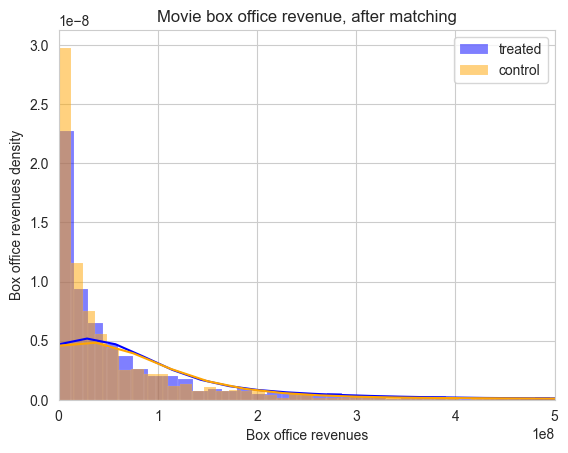

In [72]:
ax = sns.histplot(treated['Movie_box_office_revenue'], kde=True, stat='density', color='blue', label='treated');
ax = sns.histplot(control['Movie_box_office_revenue'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Movie box office revenue, after matching',xlabel='Box office revenues', ylabel='Box office revenues density')
plt.xlim(0, 0.5e9)
plt.legend()
plt.show()

We see that the treatment group has higher mean, 25%, median and 75% quantiles than the contorl group.
But are these differences significantly higher? Let's use a t-test. This is a two-sided test for the null hypothesis that the two independent samples have identical average (expected) values. 

In [73]:
stats.ttest_ind(control['Movie_box_office_revenue'], treated['Movie_box_office_revenue'])

TtestResult(statistic=-1.3393071746108602, pvalue=0.18058145408042112, df=2748.0)

The p-value is greater than 0.05, we hence cannot reject the null hypothesis that the box office revenue is the same between the two groups.


Going further and trying to plot the mean box office revenue between the two groups, we see that the confidence intervals intercept each other and we hence conclude that there is no significant difference between the groups.

In [74]:
# Computing means and confidence intervals
treated_mean = treated['Movie_box_office_revenue'].mean()
control_mean = control['Movie_box_office_revenue'].mean()

treated_ci = 1.96 * treated['Movie_box_office_revenue'].std() / np.sqrt(len(treated))
control_ci = 1.96 * control['Movie_box_office_revenue'].std() / np.sqrt(len(control))

# Create the figure
fig = go.Figure()

# Add bar plots
categories = ['Movies with oscar nominated actor(s)', 'Movies without oscar nominated actor(s)']
means = [treated_mean, control_mean]
cis = [treated_ci, control_ci]
colors = ['#1f77b4', '#ff7f0e']

for category, mean, ci, color in zip(categories, means, cis, colors):
    fig.add_trace(go.Bar(
        name=category,
        x=[category],
        y=[mean],
        error_y=dict(type='data', array=[ci], visible=True),
        marker_color=color
    ))

# Customize the layout
fig.update_layout(
    title='Comparison of Mean Box Office Revenue with Confidence Intervals',
    yaxis=dict(title='Mean Box Office Revenue'),
    showlegend=False
)

# Save the plot as an interactive HTML file
fig.write_html("./box_office_revenue_comparison_after_first_matching.html")

# Show the plot
fig.show()


We can now take conclusion from our observational study. The high p-value and the overlapping confidence intervals suggest to us that there is no statiscally significant difference between the groups. But we are not done yet for our data story, we would like to tell to film directors how manyoscar nominated actors they should hire for their next movie, not only saying that having only one of them does not increase their chances at performing at the box office revenues. Maybe we could discover something if we shift our threshold a little bit higher and separate the treatment and the control groups on whether they have at least two oscar nominated actors.

We redo basically the exact same observational study as before.

In [75]:
movies_second_study = movies.copy()
movies_second_study = movies_second_study[['Movie_box_office_revenue','budget','number_of_actors', 'number_of_oscar_actors']]
movies_second_study['has_two_or_more_oscar_actors'] = movies_second_study['number_of_oscar_actors'].map(lambda x : x>=2)

In [76]:
movies_second_study['has_two_or_more_oscar_actors'] = movies_second_study['has_two_or_more_oscar_actors'].astype(int)

In [77]:
# let's standardize the continuous features
movies_second_study['budget'] = (movies_second_study['budget'] - movies_second_study['budget'].mean()) /movies_second_study['budget'].std()
movies_second_study['number_of_actors'] = (movies_second_study['number_of_actors'] - movies_second_study['number_of_actors'].mean()) /movies_second_study['number_of_actors'].std()

In [78]:
#Drop the movies with no budget
movies_second_study.dropna(subset = ['budget'], inplace = True)

In [79]:
# Select the features for regression
X = movies_second_study[['budget','number_of_actors']] 
y = movies_second_study['has_two_or_more_oscar_actors']

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Extract the estimated propensity scores
movies_second_study['Propensity_score'] = result.predict()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.633086
         Iterations 6
                                Logit Regression Results                                
Dep. Variable:     has_two_or_more_oscar_actors   No. Observations:                 4806
Model:                                    Logit   Df Residuals:                     4803
Method:                                     MLE   Df Model:                            2
Date:                          Fri, 22 Dec 2023   Pseudo R-squ.:                 0.08664
Time:                                  19:48:35   Log-Likelihood:                -3042.6
converged:                                 True   LL-Null:                       -3331.2
Covariance Type:                      nonrobust   LLR p-value:                4.505e-126
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const           

In [80]:
# Separate the control and the treated groups
treated_study = movies_second_study[movies_second_study['has_two_or_more_oscar_actors'] ==1]
control_study = movies_second_study[movies_second_study['has_two_or_more_oscar_actors'] ==0]

In [81]:
matching = perform_matching(control_study, treated_study)

In [82]:
# Grouping all the matched movies in a list
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [83]:
movies['has_two_or_more_oscar_actors'] = movies['number_of_oscar_actors'].map(lambda x : x >=2)

In [84]:
balanced_movies_study = movies.loc[matched]

In [85]:
treated = balanced_movies_study.loc[balanced_movies_study['has_two_or_more_oscar_actors'] == True] #Movies that received the treatment 
control = balanced_movies_study.loc[balanced_movies_study['has_two_or_more_oscar_actors'] ==False] #Movies that didn't receive the treatment

Now we can again compare the box office revenues using t-tests and confidence intervals.

In [86]:
treated.Movie_box_office_revenue.describe()

count    2.394000e+03
mean     1.849833e+08
std      3.132022e+08
min      1.202375e+01
25%      2.662143e+07
50%      8.399253e+07
75%      2.164073e+08
max      7.443341e+09
Name: Movie_box_office_revenue, dtype: float64

In [87]:
control.Movie_box_office_revenue.describe()

count    2.394000e+03
mean     9.438584e+07
std      2.703707e+08
min      1.698422e+00
25%      7.488512e+06
50%      3.054587e+07
75%      9.143861e+07
max      7.485431e+09
Name: Movie_box_office_revenue, dtype: float64

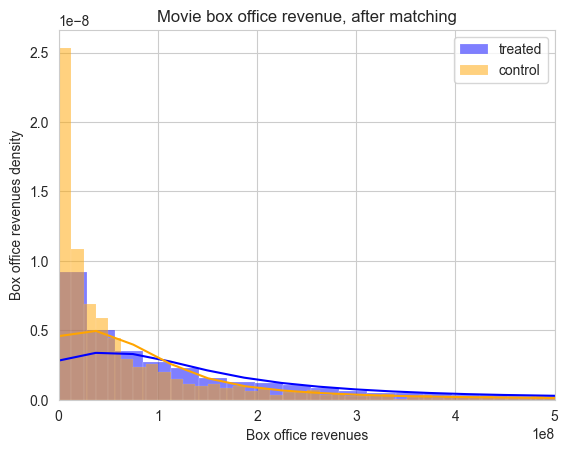

In [88]:
ax = sns.histplot(treated['Movie_box_office_revenue'], kde=True, stat='density', color='blue', label='treated');
ax = sns.histplot(control['Movie_box_office_revenue'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Movie box office revenue, after matching',xlabel='Box office revenues', ylabel='Box office revenues density')
plt.xlim(0, 0.5e9)
plt.legend()
plt.show()

In [89]:
stats.ttest_ind(control['Movie_box_office_revenue'], treated['Movie_box_office_revenue'])

TtestResult(statistic=-10.71350441770935, pvalue=1.752347274964076e-26, df=4786.0)

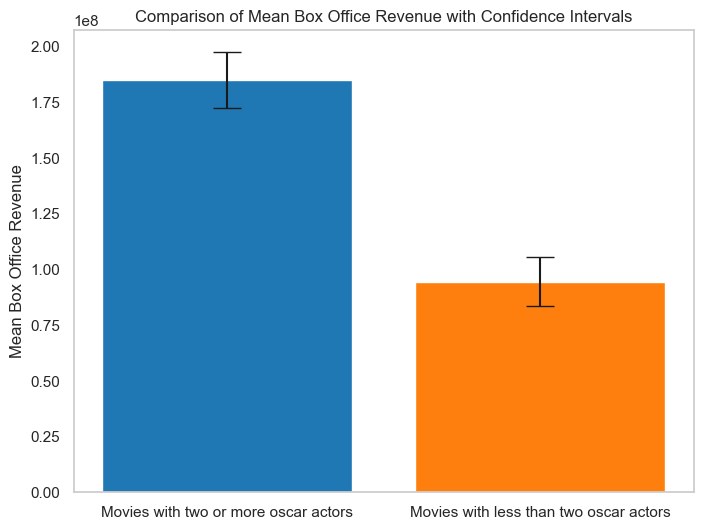

In [90]:
treated_mean = treated['Movie_box_office_revenue'].mean()
control_mean = control['Movie_box_office_revenue'].mean()

treated_ci = 1.96 * treated['Movie_box_office_revenue'].std() / np.sqrt(len(treated))
control_ci = 1.96 * control['Movie_box_office_revenue'].std() / np.sqrt(len(control))

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the figure and axes
plt.figure(figsize=(8, 6))

# Plotting
plt.bar('Movies with two or more oscar actors', treated_mean, yerr=treated_ci, color='#1f77b4', capsize=10)
plt.bar('Movies with less than two oscar actors', control_mean, yerr=control_ci, color='#ff7f0e', capsize=10)

# Customize the plot
plt.title('Comparison of Mean Box Office Revenue with Confidence Intervals')
plt.ylabel('Mean Box Office Revenue')

plt.grid(False)

# Show the plot
plt.show()


We can now take conclusions from our second observational study. The low p-value suggests to us that we can confidently reject the null hypothesis that the box office revenues from the two groups follow a similar distribution. Moreover, the non overlapping confidence intervals for the means lets us say that having two or more oscar nominated actors in your cast effectively drastically increases your box office revenues ! and now we are done !


#### Who are the most popular actors during the past three decades ?

Another interesting question we can ask ourselves is to know who were the most popular actors during the last three decades. For the purpose of this study, we will only consider movies between 1983 and 2023 with an average rating of 6 out of 10 or better that recolted at least 50 ratings or more, this is to rule out movies that may have received few good ratings.  We will then dive deeper into our data by conducting a graph study in order to explore the relationships between actors that played in popular movies and extract the most important actors.

In [99]:
def get_actor_mean_revenues(known_for_movies_1, known_for_movies_2, movies):
    """
    Calculates the mean box office revenue for movies in which two actors have played together.
    
    Parameters:
    known_for_movies_1 (list): List of movies actor 1 played in.
    known_for_movies_2 (list): List of movies actor 2 played in.
    movies (pd.DataFrame): DataFrame with 'Movie_name' and 'Movie_box_office_revenue' columns.
    
    Returns:
    float: Mean box office revenue of the movies both actors played in together. Returns 0 if no common movies.
    """
    # Find common movies
    common_movies = set(known_for_movies_1).intersection(set(known_for_movies_2))

    # Check if there are common movies
    if not common_movies:
        return 0

    # Filter the movies DataFrame for common movies
    common_movies_data = movies[movies['Movie_name'].isin(common_movies)]

    # Calculate the mean box office revenue
    mean_revenue = common_movies_data['Movie_box_office_revenue'].mean()

    return mean_revenue

In [100]:
def weighted_degree_centrality(graph):
    """
    Calculate the weighted degree centrality for each node of the graph

    Parameters:
    graph : the weighted graph for which we want to compute the weighted degree centralities.

    Returns:
    a dictionnary associating to each node a degree of centrality.
    """
    centrality = {}
    for node in graph.iterNodes():
        weight_sum = sum(graph.weight(node, neighbor) for neighbor in graph.iterNeighbors(node))
        centrality[node] = weight_sum
    return centrality

In [101]:
def conduct_study(start_year, end_year, characters) :
    """
    Conducts a graph study to extract and plot the ten most influent actors between start_year and end_year.
    The function creates an undirected weighted graph only considering the movies released between start_year and end_year
    where each node is an actor and where the weight between two actors is the mean of the box office revenues of the movies they played in together.
    the function then computes the weighted degree centralities for each actor in the graph and outputs the ten most central actors.
    """
    popular_movies = movies[movies['Movie_box_office_revenue'] >= movies['Movie_box_office_revenue'].quantile(0.90)]
    popular_movies = movies[(movies['year'] >= start_year) & (movies['year'] <= end_year)]
    popular_movies = popular_movies[['Freebase_Movie_ID', 'Movie_name']]
    # Merge the popular movies into the characters dataframe so that each character is associated with the popular movie name he played in.
    characters = characters.merge(popular_movies, on = 'Freebase_Movie_ID')
    # Associate to each actor the list of popular movies he played in.
    characters = characters.groupby('Actor_Name')['Movie_name'].apply(list).reset_index(name="Known_for_popular_movies")

    characters = characters[characters['Known_for_popular_movies'].apply(lambda x: len(x) >3)]
    # Initialize Graph
    G = nk.Graph(weighted=True)

    actor_to_node = {} # Dictionnary to store association from actor names to node ids.
    node_to_actor = {} # Dictionnary to store association from node ids to actor names.
    
    # Add nodes
    for i, row in characters.iterrows(): 
        actor_node = G.addNode()
        actor_to_node[row['Actor_Name']] = actor_node
        node_to_actor[actor_node] = row['Actor_Name']

    # Add edges
    for i, row_i in characters.iterrows():
        for j, row_j in characters.iterrows():
            if i < j:
                # Calculate the number of common movies
                mean_revenues = get_actor_mean_revenues(row_i['Known_for_popular_movies'], row_j['Known_for_popular_movies'], movies = movies)
                if mean_revenues > 0:
                    G.addEdge(actor_to_node[row_i['Actor_Name']], actor_to_node[row_j['Actor_Name']], mean_revenues)

    centrality_scores = weighted_degree_centrality(G)
    # Normalize the centrality scores
    min_score = min(centrality_scores.values())
    max_score = max(centrality_scores.values())
    normalized_scores = {node: (score - min_score) / (max_score - min_score) for node, score in centrality_scores.items()}
    # Extract top 10 actors
    top_actors = sorted(normalized_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    actor_names = [node_to_actor[node] for node, _ in top_actors]
    scores = [score for _, score in top_actors]
    # Generate colors for each actor using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(actor_names)))
    colors_rgb = ['rgba({},{},{},1)'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

    # Plotting the bar chart using Plotly
    fig = go.Figure(data=[
        go.Bar(
            x=actor_names, 
            y=scores, 
            marker_color=colors_rgb
        )
    ])

    # Customize the layout
    fig.update_layout(
        title=f'Top 10 Most Influential Actors Based on Normalized Centrality Scores ({start_year}-{end_year})',
        xaxis_title='Actors',
        yaxis_title='Normalized Centrality Scores',
        xaxis_tickangle=45,
        showlegend=False  # Hides the legend as it's not necessary
    )

    # Show the plot
    fig.show()

    # Save the plot as an interactive HTML file
    filename = f'actors_{start_year}_{end_year}.html'
    fig.write_html(filename)

In [102]:
conduct_study(1970, 1979,characters=characters)

In [103]:
conduct_study(1980, 1989,characters=characters)

In [104]:
conduct_study(1990, 1999, characters=characters)

In [105]:
conduct_study(2000, 2009, characters=characters)

In [106]:
conduct_study(2010, 2019, characters=characters)

### Conclusion : 

This network study helped us see who were the most central actors for the past 5 decades. Feel free to play with the code for performing the study some other time laps. Note that however the way we construct our graph gives the same weights to primary and secondary actors for the same movies since the study does not consider the roles in the movies, hence our study may be a little bit biased to bring to light actors that tend to have lots of secondary roles in a lot of movies. 

# Sub-question 5: What is the relationship between a movies runtime and it's subsequent success?

In [145]:
# For our plot we will remove outliers so as to get a better view of the distribution and not stretch the plot too much

movies_runtime = movies.copy()

Q1 = np.nanpercentile(movies_runtime['Movie_runtime'], 25)
Q3 = np.nanpercentile(movies_runtime['Movie_runtime'], 75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

merged_df = movies_runtime[(movies_runtime['Movie_runtime'] > lower) & (movies_runtime['Movie_runtime'] < upper)]

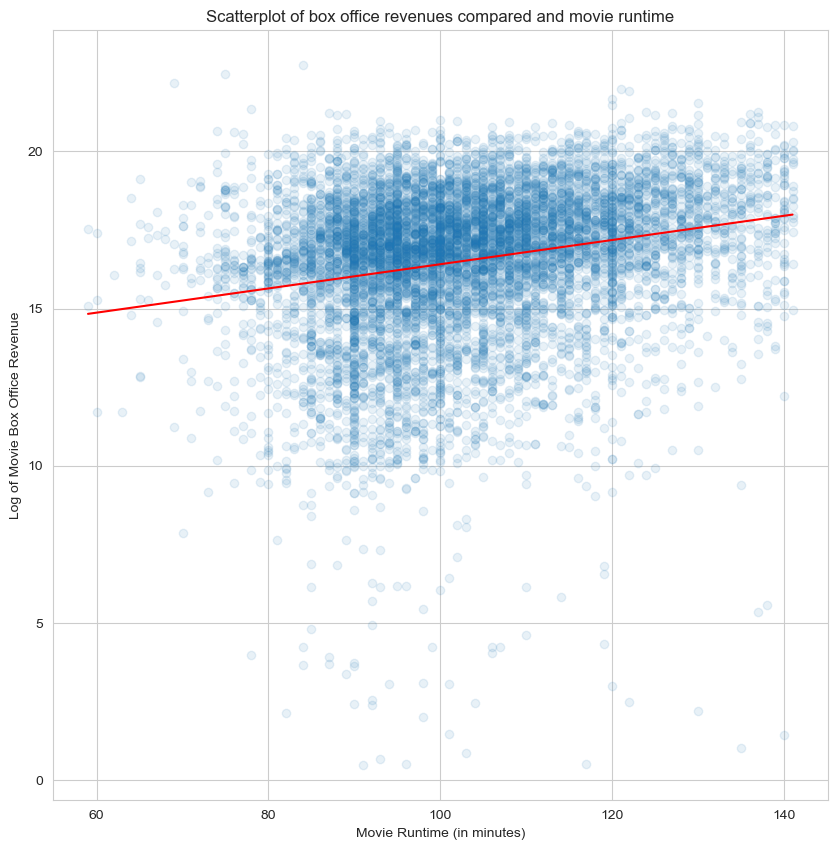

In [137]:
# We will use the log of the revenue to make it more representative
x = plotting_data["Movie_runtime"]
y = np.log(plotting_data["Movie_box_office_revenue"])

# Scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(x, y, alpha=0.1)

# Linear Regression
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
x_range = np.linspace(x.min(), x.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_range, color='red')

# Labels and Title
plt.xlabel('Movie Runtime (in minutes)')
plt.ylabel('Log of Movie Box Office Revenue')
plt.title('Scatterplot of box office revenues compared and movie runtime')

# Show the plot
plt.show()

- By inspecting the plot we notice that the majority of movies are between 60 minutes and 130 in length (after removing outliers in our data, for example movies that last for 5 hours)

- When we look at this plot we could wonder if there exists a connection between movie runtime and it's subsequent revenue. This question will be investigated further later on in the report.

## So the question that we ask is: How does a movies runtime affect it's subsequent box office revenue?

First let's take a closer look at the distribution of the movie runtimes

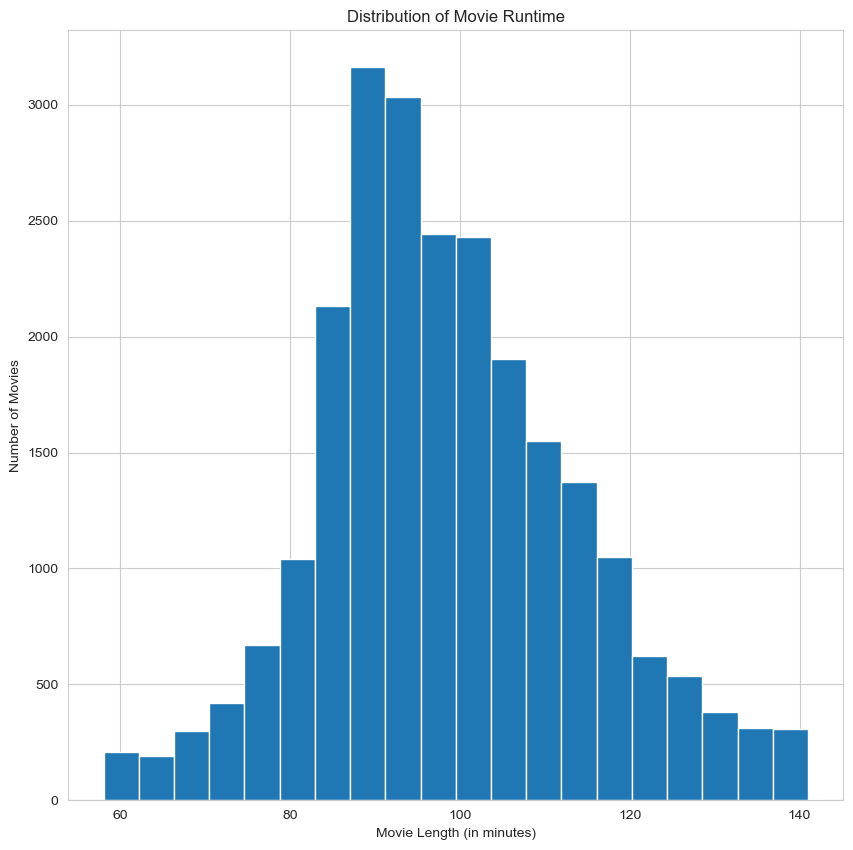

In [141]:
data = merged_df['Movie_runtime'].dropna()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Create a histogram
n, bins, patches = ax.hist(data, bins=20)

# Add labels and title
ax.set_xlabel('Movie Length (in minutes)')
ax.set_ylabel('Number of Movies')
ax.set_title('Distribution of Movie Runtime')

# Show the plot
plt.show()

**Again we can see that most movies are within a range of 60-130 minutes of length with most being around 90 minutes in length**

Now let's answer the question about whether movie runtime affects box office revenue$\rightarrow$We start off by doing a linear regression to see how the variables interact with each other

In [79]:
# Regression analysis
runtime_regression = smf.ols(
    "Movie_box_office_revenue ~ Movie_runtime", data = movies 
).fit()

#Summary
runtime_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.031
Model:                                  OLS   Adj. R-squared:                  0.031
Method:                       Least Squares   F-statistic:                     289.6
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):           6.12e-64
Time:                              16:09:16   Log-Likelihood:            -1.8403e+05
No. Observations:                      8913   AIC:                         3.681e+05
Df Residuals:                          8911   BIC:                         3.681e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.849e+07   1.12e+07     -8.822      0.000    -1.2e+08   -7.66e+07
Movie_runtime  1.743e+06   1.02e+05     17.018      0.000    1.54e+06    1.94e+06
==============================================================================
Omnibus:                    16433.084   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         42901209.988
Skew:                          13.519   Prob(JB):                         0.00
Kurtosis:                     341.805   Cond. No.                         512.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Comments:

- The R-squared statistic is very low (R-squared = 0.031) meaning that the movie runtime variable only explains 3.1% of the variance in the movie box office revenue. $\implies$ movie runtime is not an important predictor for the movies success, even if it is statistically significant (p-value < 0.05) and the F-statistic is high.

- We could also wonder if the movie runtime is Normally distributed as our many things in the world, since knowing the form of the distribution could give us more insight into the relationship between movie runtime and it's revenue.

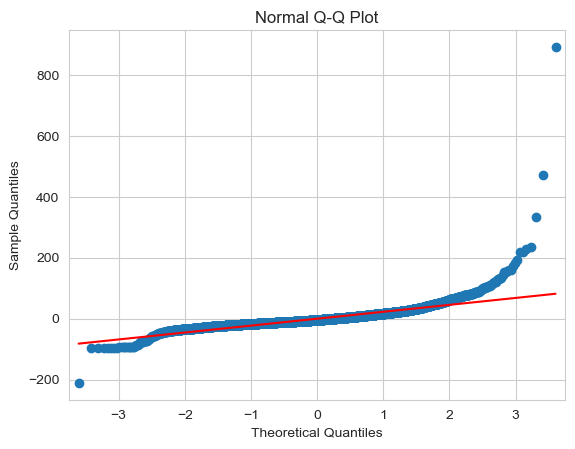

In [157]:
# We use a Q-Q plot to compare the theoretical normal distribution with our true distribution
qqplot(runtime_regression.resid, line='r')
plt.title('Normal Q-Q Plot')
plt.show()

### Comments:

- The central part of our distribution follows a normal distribution very closely while its tails tend to diverge since our distribution is more heavy tailed than a normal distribution. So it can be seen as close to a normal distribution closer to the center where there are less extreme runtimes

## In this next section we will find out if there is a significant difference in movie runtime when it comes to blockbuster movies and non-blockbuster movies

To achieve this, we partition our data into 2 groups, one being a "blockbuster group" (which consists of movies with over 400$ million in box office revenue) and the other a "non blockbuster group" but in order to ensure that we are comparing similar groups with similar characteristics we apply exact matching on the Genres since this is one of the biggest confounders that would affect our runtime distribution.

For example, documentaries will naturally last longer than action films so comparing runtimes for different categories of revenues would not make sense. So using exact matching we mitigate the effects of this confounder.

### Without any matching we obtain the following results

In [160]:
def categorize_revenue(revenue, threshold):
    return 'blockbuster' if revenue >= threshold else 'non-blockbuster'

# Set your revenue threshold for blockbuster movies
revenue_threshold = 400000000  # 400 million revenue is considered a blockbuster

blockbuster_movies = movies.copy().dropna(subset=['Movie_box_office_revenue', 'Movie_runtime'])
blockbuster_movies['revenue_category'] = blockbuster_movies['Movie_box_office_revenue'].apply(lambda x: categorize_revenue(x, revenue_threshold))

# Separate into blockbuster and non-blockbuster groups
blockbuster_group = blockbuster_movies[blockbuster_movies['revenue_category'] == 'blockbuster']
non_blockbuster_group = blockbuster_movies[blockbuster_movies['revenue_category'] == 'non-blockbuster']

# Determine the number of movies to sample (minimum count from blockbuster and non-blockbuster groups)
min_count = min(blockbuster_group.shape[0], non_blockbuster_group.shape[0])

# Check if there are enough movies for the t-test
if min_count > 0:
    # Sample the same number of movies from each revenue category
    blockbuster_sample = blockbuster_group.sample(n=min_count, random_state=42)
    non_blockbuster_sample = non_blockbuster_group.sample(n=min_count, random_state=42)

    # Concatenate the balanced data
    unbalanced_data = pd.concat([blockbuster_sample, non_blockbuster_sample])

    # Perform t-test on the balanced data
    t_stat, p_value = ttest_ind(
        unbalanced_data[unbalanced_data['revenue_category'] == 'blockbuster']['Movie_runtime'],
        unbalanced_data[unbalanced_data['revenue_category'] == 'non-blockbuster']['Movie_runtime'],
        equal_var=False
    )

    # Print results
    print(f'Test for all movies: t-statistic = {t_stat}, p-value = {p_value}')
else:
    print('Not enough movies for the t-test.')


Test for all movies: t-statistic = 9.063045295037817, p-value = 1.4446715268136271e-18


### Now using matching we get the following results

In [161]:
from scipy.stats import ttest_ind

def categorize_revenue(revenue, threshold):
    return 'blockbuster' if revenue >= threshold else 'non-blockbuster'

revenue_threshold = 400000000  # 400 million revenue is considered a blockbuster

blockbuster_movies = movies.copy().dropna(subset=['Movie_box_office_revenue', 'Movie_runtime'])
blockbuster_movies['revenue_category'] = blockbuster_movies['Movie_box_office_revenue'].apply(lambda x: categorize_revenue(x, revenue_threshold))
exploded_blockbuster = blockbuster_movies.explode('genres')

balanced_data = pd.DataFrame(columns=exploded_blockbuster.columns)

# Perform t-test for each genre
for genre, group in exploded_blockbuster.groupby('genres'):
    # Separate into blockbuster and non-blockbuster groups
    blockbuster_group = group[group['revenue_category'] == 'blockbuster']
    non_blockbuster_group = group[group['revenue_category'] == 'non-blockbuster']

    # Determine the number of movies to sample (minimum count from blockbuster and non-blockbuster groups)
    min_count = min(blockbuster_group.shape[0], non_blockbuster_group.shape[0])

    # Check if there are enough movies for the t-test
    if min_count > 0:
        # Sample the same number of movies from each revenue category
        blockbuster_sample = blockbuster_group.sample(n=min_count, random_state=42)
        non_blockbuster_sample = non_blockbuster_group.sample(n=min_count, random_state=42)

        # Concatenate the balanced data for this genre
        balanced_data = pd.concat([balanced_data, blockbuster_sample, non_blockbuster_sample])

# Perform t-test on the balanced data
t_stat, p_value = ttest_ind(
balanced_data[balanced_data['revenue_category'] == 'blockbuster']['Movie_runtime'],
balanced_data[balanced_data['revenue_category'] == 'non-blockbuster']['Movie_runtime'],
equal_var=False
)

# Print results
print(f'Test for all genres: t-statistic = {t_stat}, p-value = {p_value}')


Test for all genres: t-statistic = 15.84333726949741, p-value = 2.0304634258000265e-53


Without matching, the t-statistic is smaller indicating that the genres are indeed an important factor to take into account since the average movie runtimes are closer when we fail to match on genres since certain genres naturally have longer runtimes, meaning that if there are more genres either in the 'blockbuster' category or 'non-blockbuster' category the t-statistic will be altered.

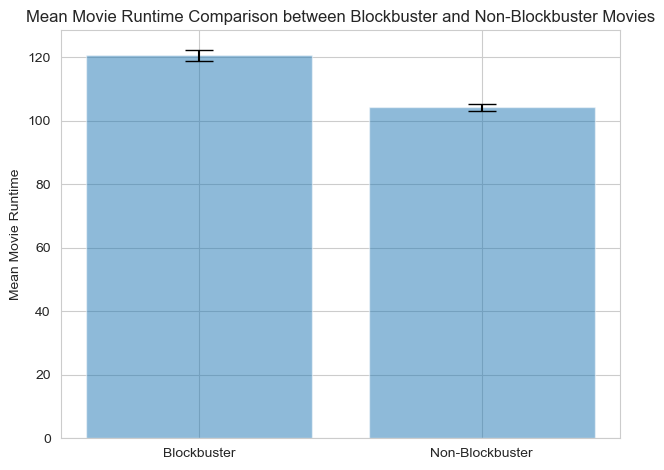

In [156]:
# Calculate mean and confidence interval for blockbuster movies
# Since the means are normally distributed we can apply the formula below for calculating their 95% confidence intervals.
mean_blockbuster = balanced_data[balanced_data['revenue_category'] == 'blockbuster']['Movie_runtime'].mean()
ci_blockbuster = 1.96 * balanced_data[balanced_data['revenue_category'] == 'blockbuster']['Movie_runtime'].std() / np.sqrt(len(balanced_data[balanced_data['revenue_category'] == 'blockbuster']['Movie_runtime']))

# Calculate mean and confidence interval for non-blockbuster movies
mean_non_blockbuster = balanced_data[balanced_data['revenue_category'] == 'non-blockbuster']['Movie_runtime'].mean()
ci_non_blockbuster = 1.96 * balanced_data[balanced_data['revenue_category'] == 'non-blockbuster']['Movie_runtime'].std() / np.sqrt(len(balanced_data[balanced_data['revenue_category'] == 'non-blockbuster']['Movie_runtime']))


# Data
categories = ['Blockbuster', 'Non-Blockbuster']
mean_values = [mean_blockbuster, mean_non_blockbuster]
ci_values = [ci_blockbuster, ci_non_blockbuster]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create a bar plot
bars = ax.bar(categories, mean_values, yerr=ci_values, align='center', alpha=0.5, ecolor='black', capsize=10)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Movie Runtime')
ax.set_title('Mean Movie Runtime Comparison between Blockbuster and Non-Blockbuster Movies')
ax.set_xticks(categories)

# Save the figure and show
plt.tight_layout()
plt.show()

In [85]:
print(f"Average Movie Runtime for Blockbuster Movies: {balanced_data[balanced_data['revenue_category'] == 'blockbuster']['Movie_runtime'].mean()}")
print(f"Average Movie Runtime for Non-Blockbuster Movies: {balanced_data[balanced_data['revenue_category'] == 'non-blockbuster']['Movie_runtime'].mean()}")

Average Movie Runtime for Blockbuster Movies: 120.67599660729432
Average Movie Runtime for Non-Blockbuster Movies: 104.2832909245123


Comments:

- Simply by inspecting the means of the 2 datasets we already observe a difference in the means although we have not used matching on the genres yet, so we should be wary of what we observe since there are unobserved confounders.

- We can also see that the confidence intervals for the means of blockbuster and non-blockbuster movies are far apart without any overlap so we expect there to be a difference that is statistically significant.

- When doing a student test and doing matching we observe that the mean of the first group is larger than the mean of the second group (since the t-statistic is positive) and the associated p-value is small (less than the threshold of 0.05) indicating that we can reject the null Hypothesis, i.e we can say that the hypothesis stating that "Both big blockbusters and small blockbusters have the same runlength" is false indicating that runtime does have an affect on movie revenue.

# Sub-question 6: What effect does the movies budget have on it's success?

We start off by doing a linear regression between the movie budgets and box office revenues to gain insight into the linear dependance between them.

In [87]:
# Regression analysis inspecting the effect of the movie budget on it's box office revenue
budget_regression = smf.ols(
    "Movie_box_office_revenue ~ budget", data = movies 
).fit()

#Summary
budget_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.165
Model:                                  OLS   Adj. R-squared:                  0.165
Method:                       Least Squares   F-statistic:                     995.4
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):          1.59e-199
Time:                              16:09:54   Log-Likelihood:            -1.0489e+05
No. Observations:                      5038   AIC:                         2.098e+05
Df Residuals:                          5036   BIC:                         2.098e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.667e+07   4.92e+06      7.452      0.000     2.7e+07    4.63e+07
budget         2.2622      0.072     31.550      0.000       2.122       2.403
==============================================================================
Omnibus:                     8992.117   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18123483.533
Skew:                          12.561   Prob(JB):                         0.00
Kurtosis:                     295.755   Cond. No.                     8.99e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.99e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- R-squared = 0.165 meaning that 16.5 % of the variance in the dependant variable (i.e movie box office revenue) is explained by the budget of the movie. This is to be expected since movies with bigger budgets tend to perform better than movies with lower ones.

- This result shows that the budget explains much more variance in the movie's success than the movie runtime does

In [88]:
exploded_df_groups = exploded_df.groupby('genres')

In [89]:
mean_revenue = exploded_df_groups['Movie_box_office_revenue'].mean()

In [90]:
mean_budget = exploded_df_groups['budget'].mean()

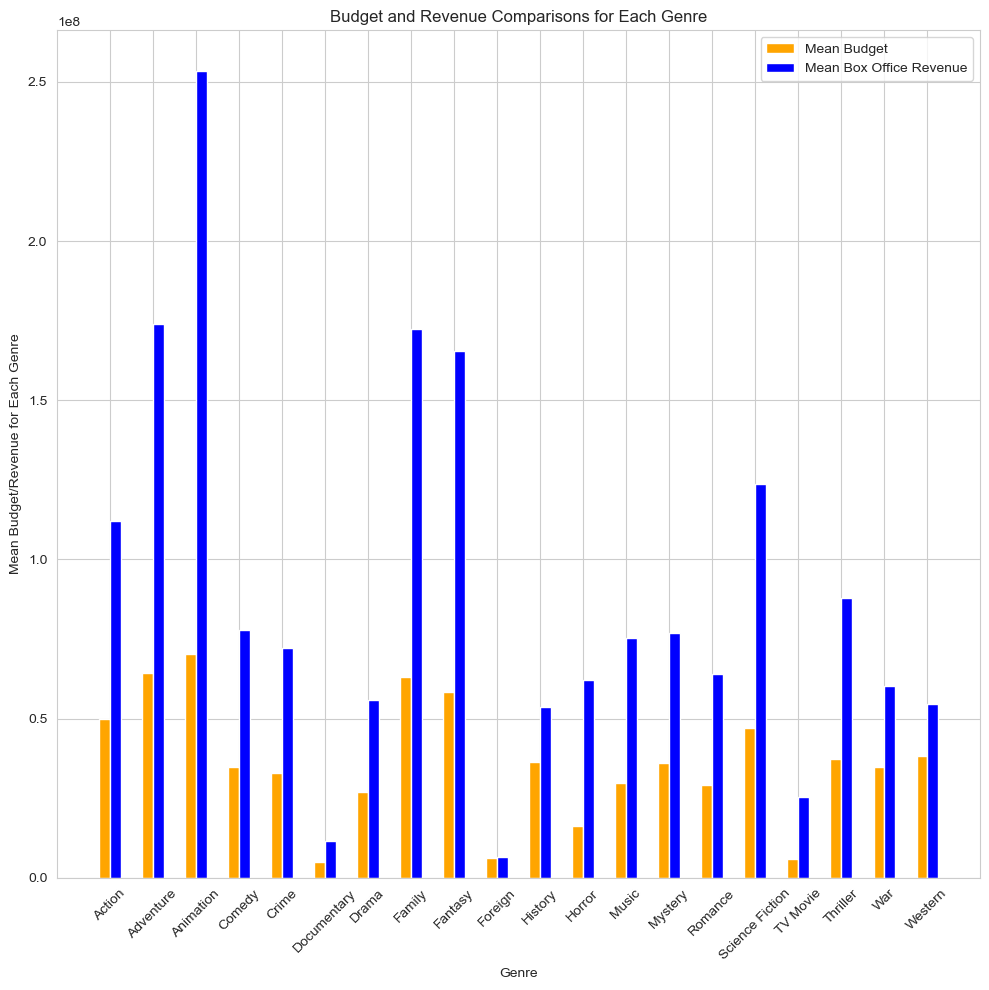

In [144]:
# Data
r = np.arange(len(mean_budget))
width = 0.25

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Bar for mean budget
ax.bar(r, mean_budget.values, width, label='Mean Budget', color='orange')

# Bar for mean box office revenue
ax.bar(r + width, mean_revenue.values, width, label='Mean Box Office Revenue', color='blue')

# Add labels and title
ax.set_xlabel('Genre')
ax.set_ylabel('Mean Budget/Revenue for Each Genre')
ax.set_title('Budget and Revenue Comparisons for Each Genre')
ax.set_xticks(r + width / 2)
ax.set_xticklabels(mean_budget.index, rotation=45)  # Rotate labels
ax.legend()

# Show the plot
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

Above we can see the mean box office revenue and mean revenue for each film which could lead us to the following question: do films with higher budgets also have higher box office revenues ? 

To answer this question we will seperate films into 2 catégories, one being high budget films and another being low budget films.

We will also match on the genres since depending on which genre the film comes from it could have very big differences in revenues, so we must take this confounder into account

In [148]:
def categorize_budget(budget, threshold):
    return 'low' if budget < threshold else 'high'

# Setting the budget threshold
budget_threshold = 50000000  # 50 million budget is considered high


movies_without_na = movies.copy().dropna(subset=['Net profit'])
movies_without_na['budget_category'] = movies_without_na['budget'].apply(lambda x: categorize_budget(x, budget_threshold))
exploded_movies = movies_without_na.explode('genres')

balanced_data = pd.DataFrame(columns=exploded_movies.columns)

# Perform t-test for each genre
for genre, group in exploded_movies.groupby('genres'):
    # Separate into low and high budget groups
    low_budget_group = group[group['budget_category'] == 'low']
    high_budget_group = group[group['budget_category'] == 'high']

    # Determine the number of movies to sample (minimum count from low and high budget groups)
    min_count = min(low_budget_group.shape[0], high_budget_group.shape[0])

    # Sample the same number of movies from each budget category
    low_budget_sample = low_budget_group.sample(n=min_count, random_state=42)
    high_budget_sample = high_budget_group.sample(n=min_count, random_state=42)

    # Concatenate the balanced data for this genre
    balanced_data = pd.concat([balanced_data, low_budget_sample, high_budget_sample])

# Perform t-test on the balanced data
t_stat, p_value = ttest_ind(
    balanced_data[balanced_data['budget_category'] == 'low']['Net profit'],
    balanced_data[balanced_data['budget_category'] == 'high']['Net profit'],
    equal_var=False
)
# Not assuming equal population variances

print(f'Test for all genres: t-statistic = {t_stat}, p-value = {p_value}')

Test for all genres: t-statistic = -14.451174627987395, p-value = 8.761322393345239e-47


In [149]:
print(f"Average Net Profit for Low Budget: {'{:e}'.format(balanced_data[balanced_data['budget_category'] == 'low']['Net profit'].mean())}")
print(f"Average Net Profit for High Budget: {'{:e}'.format(balanced_data[balanced_data['budget_category'] == 'high']['Net profit'].mean())}")

Average Net Profit for Low Budget: 7.147651e+07
Average Net Profit for High Budget: 1.782206e+08


**Comments:**

- As expected movies with a higher budget (categorized by budgets above 50million USD) are expected to also have higher average net profit. Simply by looking at the averages we notice that the average net profit is very different between high budget films and lower budget films.

- The p-value is almost 0 (in any case it's much lower than the 5% significance level) so the results are statistically significant and we can affirm that the hypothesis: "The mean profit of low budget movies is the same as the mean profit for high budget movies" is False. Although we cannot affirm that the alternate hypothesis is true this result does give some evidence that it's more likely given the large p-statistic and almost 0 p-value.

- These results have been obtained by applying exact matching on the movie genres in order to ensuer minimal counfounding. Since genres have varying amounts of net profit, by matching we reduce the effect of this confounder and gain better inside into the true difference in net profit which is caused by the budget.

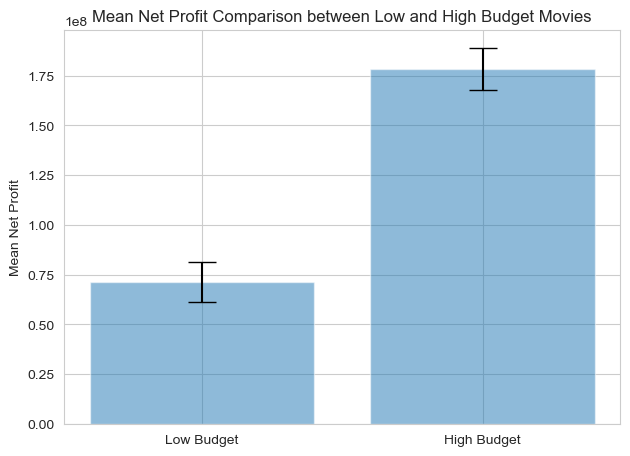

In [150]:
# Calculate mean and confidence interval for low-budget movies
mean_low_budget_net_profit = balanced_data[balanced_data['budget_category'] == 'low']['Net profit'].mean()
ci_low_budget_net_profit = 1.96 * balanced_data[balanced_data['budget_category'] == 'low']['Net profit'].std() / np.sqrt(len(balanced_data[balanced_data['budget_category'] == 'low']['Net profit']))

# Calculate mean and confidence interval for high-budget movies
mean_high_budget_net_profit = balanced_data[balanced_data['budget_category'] == 'high']['Net profit'].mean()
ci_high_budget_net_profit = 1.96 * balanced_data[balanced_data['budget_category'] == 'high']['Net profit'].std() / np.sqrt(len(balanced_data[balanced_data['budget_category'] == 'high']['Net profit']))

categories = ['Low Budget', 'High Budget']
mean_values = [mean_low_budget_net_profit, mean_high_budget_net_profit]
ci_values = [ci_low_budget_net_profit, ci_high_budget_net_profit]

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Create a bar plot
bars = ax.bar(categories, mean_values, yerr=ci_values, align='center', alpha=0.5, ecolor='black', capsize=10)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Net Profit')
ax.set_title('Mean Net Profit Comparison between Low and High Budget Movies')
ax.set_xticks(categories)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()